(GLM-robust-with-outlier-detection)=
# GLM: Robust Regression using Custom Likelihood for Outlier Classification

:::{post} 17 Nov, 2021
:tags: pymc.Bernoulli, pymc.Data, pymc.Deterministic, pymc.DiscreteUniform, pymc.Exponential, pymc.GaussianRandomWalk, pymc.HalfNormal, pymc.InverseGamma, pymc.Model, pymc.Normal, pymc.Poisson, pymc.Potential, pymc.Slice, pymc.StudentT, pymc.Uniform, regression, robust analysis
:category: intermediate
:author: Jon Sedar, Thomas Wiecki, Raul Maldonado, Oriol Abril
:::

Using PyMC for Robust Regression with Outlier Detection using the Hogg 2010 Signal vs Noise method. 

**Modelling concept:**
+ This model uses a custom likelihood function as a mixture of two likelihoods, one for the main data-generating function (a linear model that we care about), and one for outliers.
+ The model does not marginalize and thus gives us a classification of outlier-hood for each datapoint
+ The dataset is tiny and hardcoded into this Notebook. It contains errors in both the x and y, but we will deal here with only errors in y.

**Complementary approaches:**
+ This is a complementary approach to the Student-T robust regression as illustrated in the example {doc}`generalized_linear_models/GLM-robust`, and that approach is also compared
+ See also a [gist by Dan FM](https://gist.github.com/dfm/5250dd2f17daf60cbe582ceeeb2fd12f) that he published after a quick twitter conversation - his "Hogg improved" model uses this same model structure and cleverly marginalizes over the outlier class but also observes it during sampling using a `pm.Deterministic` <- this is really nice
+ The likelihood evaluation is essentially a copy of eqn 17 in "Data analysis recipes: Fitting a model to data" - {cite:t}`hogg2010data`
+ The model is adapted specifically from Jake Vanderplas' and Brigitta Sipocz' [implementation](http://www.astroml.org/book_figures/chapter8/fig_outlier_rejection.html) in the AstroML book {cite:p}`ivezić2014astroMLtext,vanderplas2012astroML`

## Setup

### Installation Notes

See the original project [README](https://github.com/jonsedar/pymc_examples/blob/master/README.md) for full details on dependencies and about the environment where the notebook was written in. A summary on the environment where this notebook was executed is available in the ["Watermark"](#watermark) section.

:::{include} ../extra_installs.md
:::

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Imports

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from matplotlib.lines import Line2D
from scipy import stats

In [3]:
az.style.use("arviz-darkgrid")

### Load Data

We'll use the Hogg 2010 data available at  https://github.com/astroML/astroML/blob/master/astroML/datasets/hogg2010test.py

It's a very small dataset so for convenience, it's hardcoded below

In [4]:
# cut & pasted directly from the fetch_hogg2010test() function
# identical to the original dataset as hardcoded in the Hogg 2010 paper

dfhogg = pd.DataFrame(
    np.array(
        [
            [1, 201, 592, 61, 9, -0.84],
            [2, 244, 401, 25, 4, 0.31],
            [3, 47, 583, 38, 11, 0.64],
            [4, 287, 402, 15, 7, -0.27],
            [5, 203, 495, 21, 5, -0.33],
            [6, 58, 173, 15, 9, 0.67],
            [7, 210, 479, 27, 4, -0.02],
            [8, 202, 504, 14, 4, -0.05],
            [9, 198, 510, 30, 11, -0.84],
            [10, 158, 416, 16, 7, -0.69],
            [11, 165, 393, 14, 5, 0.30],
            [12, 201, 442, 25, 5, -0.46],
            [13, 157, 317, 52, 5, -0.03],
            [14, 131, 311, 16, 6, 0.50],
            [15, 166, 400, 34, 6, 0.73],
            [16, 160, 337, 31, 5, -0.52],
            [17, 186, 423, 42, 9, 0.90],
            [18, 125, 334, 26, 8, 0.40],
            [19, 218, 533, 16, 6, -0.78],
            [20, 146, 344, 22, 5, -0.56],
        ]
    ),
    columns=["id", "x", "y", "sigma_y", "sigma_x", "rho_xy"],
)

dfhogg["id"] = dfhogg["id"].apply(lambda x: "p{}".format(int(x)))
dfhogg.set_index("id", inplace=True)
dfhogg.head()

x      y  sigma_y  sigma_x  rho_xy
id                                        
p1  201.0  592.0     61.0      9.0   -0.84
p2  244.0  401.0     25.0      4.0    0.31
p3   47.0  583.0     38.0     11.0    0.64
p4  287.0  402.0     15.0      7.0   -0.27
p5  203.0  495.0     21.0      5.0   -0.33

---

## 1. Basic EDA

Exploratory Data Analysis

Note:
+ this is very rudimentary so we can quickly get to the `pymc` part
+ the dataset contains errors in both the x and y, but we will deal here with only errors in y.
+ see the {cite:t}`hogg2010data` for more detail

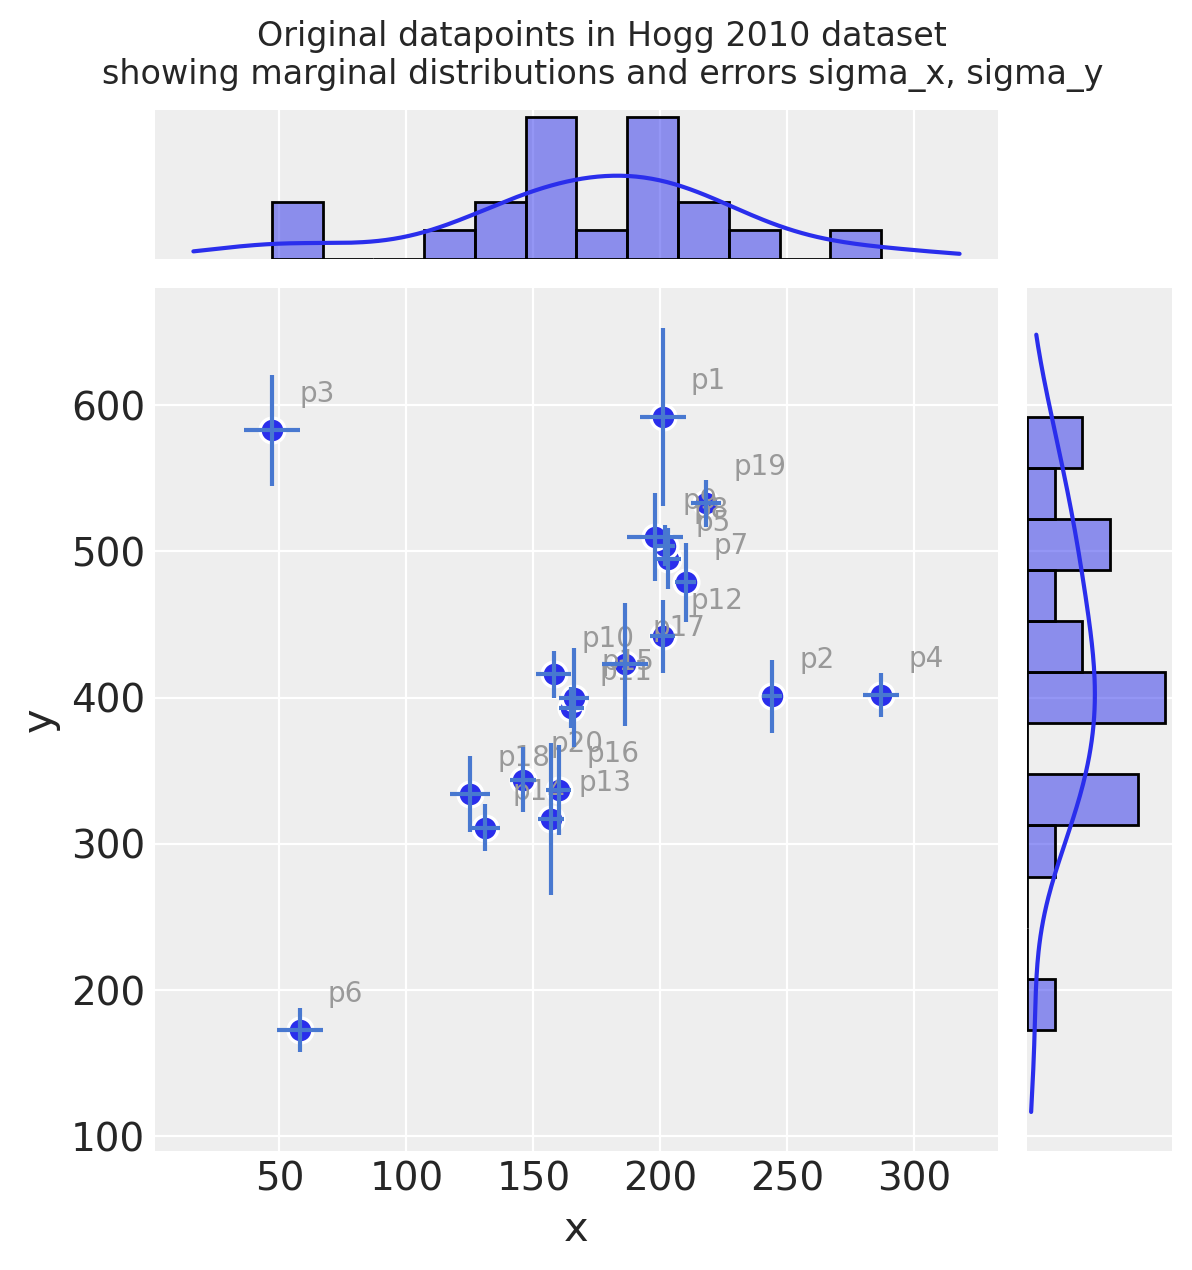

In [5]:
with plt.rc_context({"figure.constrained_layout.use": False}):
    gd = sns.jointplot(
        x="x",
        y="y",
        data=dfhogg,
        kind="scatter",
        height=6,
        marginal_kws={"bins": 12, "kde": True, "kde_kws": {"cut": 1}},
        joint_kws={"edgecolor": "w", "linewidth": 1.2, "s": 80},
    )

_ = gd.ax_joint.errorbar(
    "x", "y", "sigma_y", "sigma_x", fmt="none", ecolor="#4878d0", data=dfhogg, zorder=10
)

for idx, r in dfhogg.iterrows():
    _ = gd.ax_joint.annotate(
        text=idx,
        xy=(r["x"], r["y"]),
        xycoords="data",
        xytext=(10, 10),
        textcoords="offset points",
        color="#999999",
        zorder=1,
    )


_ = gd.fig.suptitle(
    (
        "Original datapoints in Hogg 2010 dataset\n"
        + "showing marginal distributions and errors sigma_x, sigma_y"
    ),
    y=1.05,
);

**Observe**:  

+ Even judging just by eye, you can see these observations mostly fall on / around a straight line with positive gradient
+ It looks like a few of the datapoints may be outliers from such a line
+ Measurement error (independently on x and y) varies across the observations

## 2. Basic Feature Engineering

### 2.1 Transform and standardize dataset

It's common practice to standardize the input values to a linear model, because this leads to coefficients 
sitting in the same range and being more directly comparable. e.g. this is noted in {cite:t}`gelman2008scaling`

So, following Gelman's paper above, we'll divide by 2 s.d. here

+ since this model is very simple, we just standardize directly, 
rather than using e.g. a `scikit-learn` `FunctionTransformer`
+ ignoring `rho_xy` for now

**Additional note** on scaling the output feature `y` and measurement error `sigma_y`:
+ This is unconventional - typically you wouldn't scale an output feature
+ However, in the Hogg model we fit a custom two-part likelihood function of Normals which encourages 
a globally minimised log-loss by allowing outliers to fit to their own Normal distribution. This 
outlier distribution is specified using a stdev stated as an offset `sigma_y_out` from `sigma_y`
+ This offset value has the effect of requiring `sigma_y` to be restated in the same scale as the stdev of `y`

Standardize (mean center and divide by 2 sd):

In [6]:
dfhoggs = (dfhogg[["x", "y"]] - dfhogg[["x", "y"]].mean(0)) / (2 * dfhogg[["x", "y"]].std(0))
dfhoggs["sigma_x"] = dfhogg["sigma_x"] / (2 * dfhogg["x"].std())
dfhoggs["sigma_y"] = dfhogg["sigma_y"] / (2 * dfhogg["y"].std())

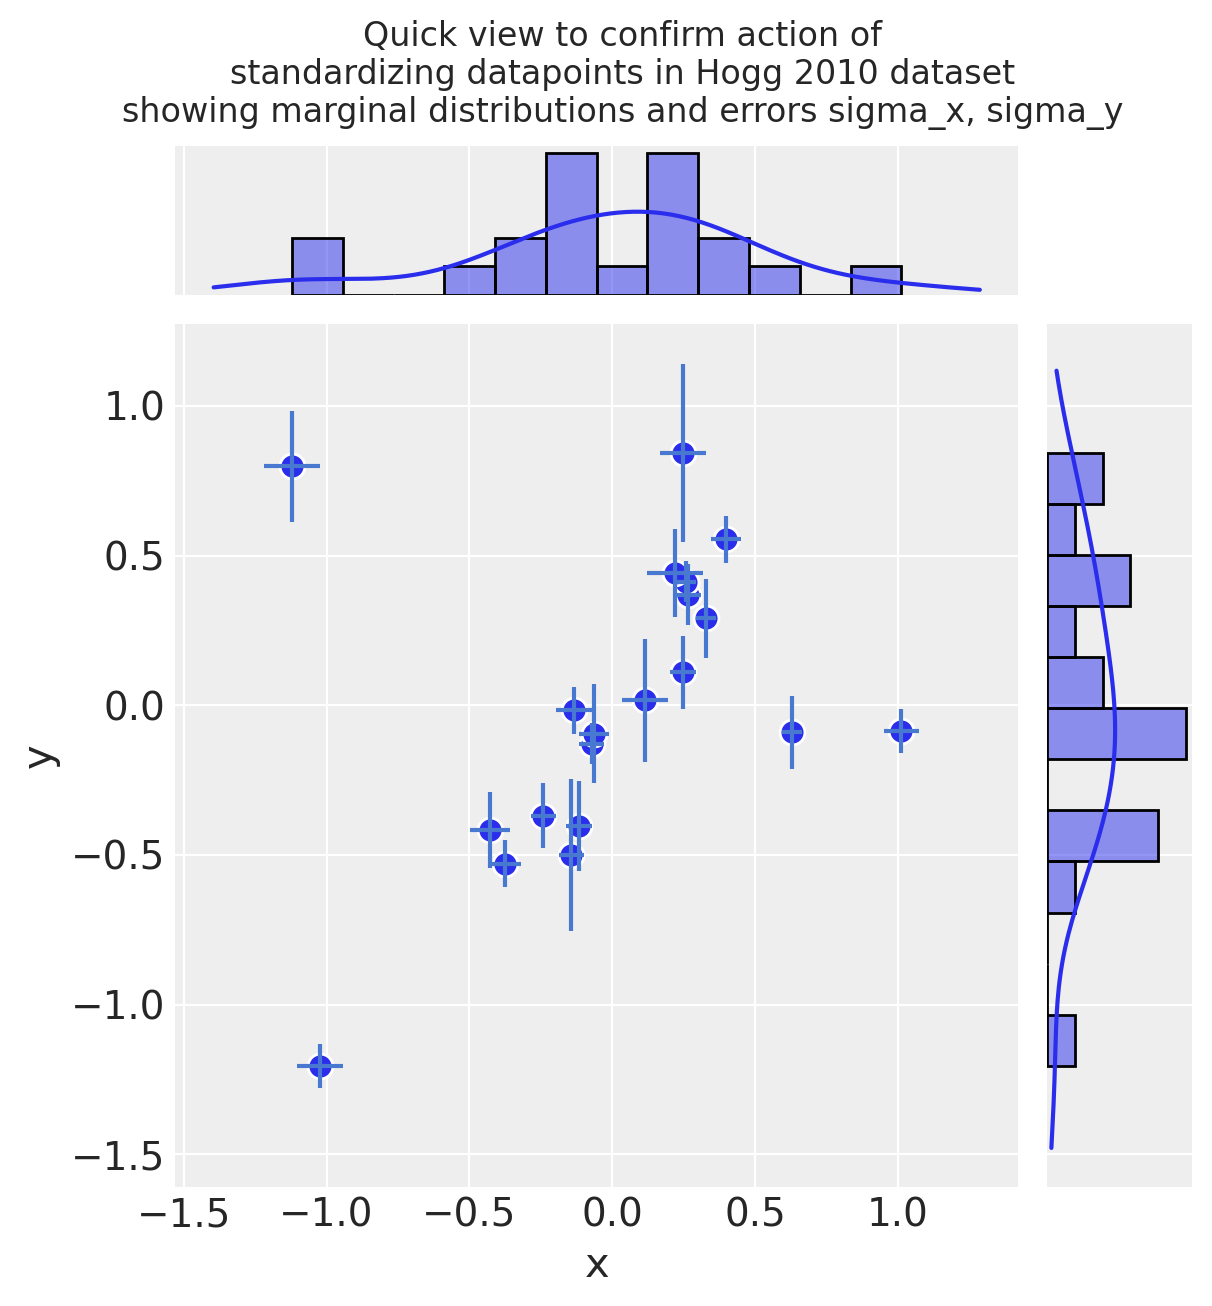

In [7]:
with plt.rc_context({"figure.constrained_layout.use": False}):
    gd = sns.jointplot(
        x="x",
        y="y",
        data=dfhoggs,
        kind="scatter",
        height=6,
        marginal_kws={"bins": 12, "kde": True, "kde_kws": {"cut": 1}},
        joint_kws={"edgecolor": "w", "linewidth": 1, "s": 80},
    )
gd.ax_joint.errorbar("x", "y", "sigma_y", "sigma_x", fmt="none", ecolor="#4878d0", data=dfhoggs)
gd.fig.suptitle(
    (
        "Quick view to confirm action of\n"
        + "standardizing datapoints in Hogg 2010 dataset\n"
        + "showing marginal distributions and errors sigma_x, sigma_y"
    ),
    y=1.08,
);

---

## 3. Simple Linear Model with no Outlier Correction

### 3.1 Specify Model

Before we get more advanced, I want to demo the fit of a simple linear model with Normal likelihood function. The priors are also Normally distributed, so this behaves like an OLS with Ridge Regression (L2 norm).

Note: the dataset also has `sigma_x` and `rho_xy` available, but for this exercise, We've chosen to only use `sigma_y`

$$\hat{y} \sim \mathcal{N}(\beta^{T} \vec{x}_{i}, \sigma_{i})$$

where:  

+ $\beta$ = $\{1, \beta_{j \in X_{j}}\}$  <--- linear coefs in $X_{j}$, in this case `1 + x`
+ $\sigma$ = error term <--- in this case we set this to an _unpooled_ $\sigma_{i}$: the measured error `sigma_y` for each datapoint

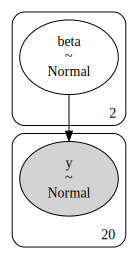

In [8]:
coords = {"coefs": ["intercept", "slope"], "datapoint_id": dfhoggs.index}
with pm.Model(coords=coords) as mdl_ols:

    ## Define weakly informative Normal priors to give Ridge regression
    beta = pm.Normal("beta", mu=0, sigma=10, dims="coefs")

    ## Define linear model
    y_est = beta[0] + beta[1] * dfhoggs["x"]

    ## Define Normal likelihood
    pm.Normal("y", mu=y_est, sigma=dfhoggs["sigma_y"], observed=dfhoggs["y"], dims="datapoint_id")

pm.model_to_graphviz(mdl_ols)

### 3.2 Fit Model

Note we are purposefully missing a step here for prior predictive checks.

#### 3.2.1 Sample Posterior

In [9]:
with mdl_ols:
    trc_ols = pm.sample(
        tune=5000,
        draws=500,
        chains=4,
        cores=4,
        init="advi+adapt_diag",
        n_init=50000,
        progressbar=True,
        ,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 10300
Interrupted at 10,299 [20%]: Average Loss = 315.9
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 5_000 tune and 500 draw iterations (20_000 + 2_000 draws total) took 5 seconds.


#### 3.2.2 View Diagnostics

NOTE: We will illustrate this OLS fit and compare to the datapoints in the final comparison plot

Traceplot

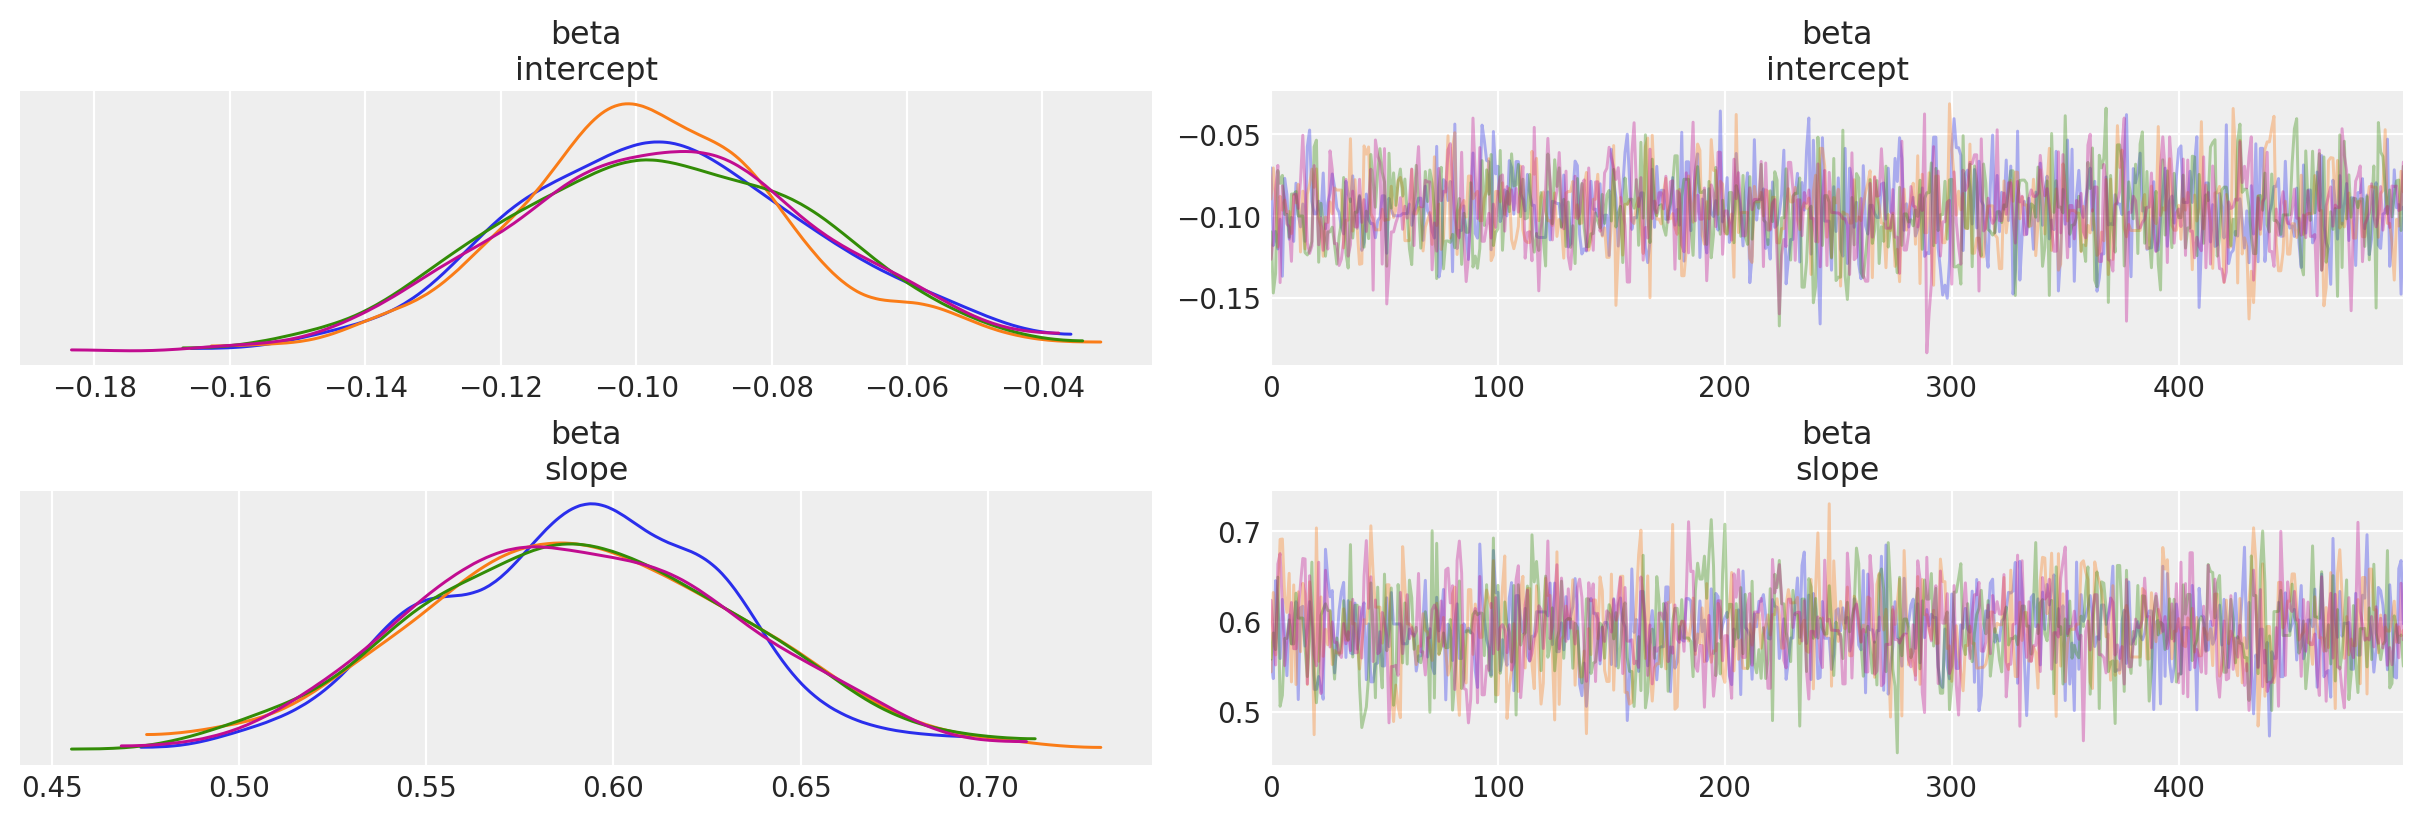

In [10]:
_ = az.plot_trace(trc_ols, compact=False)

Plot posterior joint distribution (since the model has only 2 coeffs, we can easily view this as a 2D joint distribution)

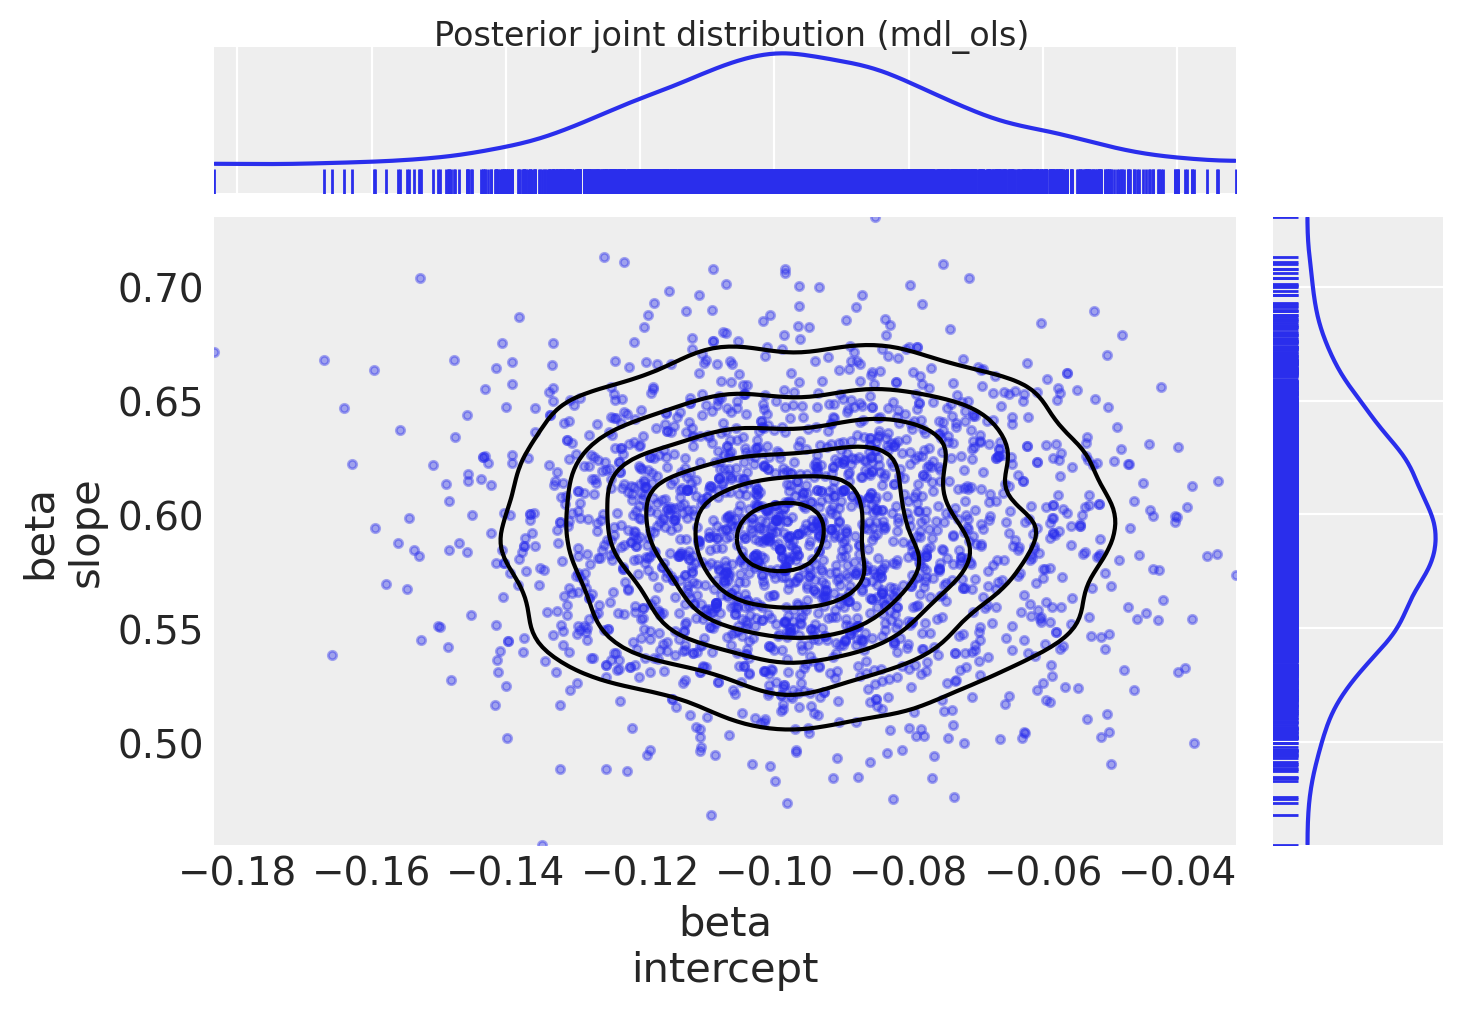

In [11]:
marginal_kwargs = {"kind": "kde", "rug": True, "color": "C0"}
ax = az.plot_pair(
    trc_ols,
    var_names="beta",
    marginals=True,
    kind=["scatter", "kde"],
    scatter_kwargs={"color": "C0", "alpha": 0.4},
    marginal_kwargs=marginal_kwargs,
)
fig = ax[0, 0].get_figure()
fig.suptitle("Posterior joint distribution (mdl_ols)", y=1.02);

## 4. Simple Linear Model with Robust Student-T Likelihood

I've added this brief section in order to directly compare the Student-T based method exampled in Thomas Wiecki's notebook in the [PyMC documentation](http://pymc-devs.github.io/pymc/GLM-robust/)

Instead of using a Normal distribution for the likelihood, we use a Student-T which has fatter tails. In theory this allows outliers to have a smaller influence in the likelihood estimation. This method does not produce inlier / outlier flags (it marginalizes over such a classification) but it's simpler and faster to run than the Signal Vs Noise model below, so a comparison seems worthwhile.

### 4.1 Specify Model

In this modification, we allow the likelihood to be more robust to outliers (have fatter tails)

$$\hat{y} \sim \text{StudentT}(\beta^{T} \vec{x}_{i}, \sigma_{i}, \nu)$$

where:  

+ $\beta$ = $\{1, \beta_{j \in X_{j}}\}$  <--- linear coefs in $X_{j}$, in this case `1 + x`
+ $\sigma$ = error term <--- in this case we set this to an _unpooled_ $\sigma_{i}$: the measured error `sigma_y` for each datapoint
+ $\nu$ = degrees of freedom <--- allowing a pdf with fat tails and thus less influence from outlier datapoints

Note: the dataset also has `sigma_x` and `rho_xy` available, but for this exercise, I've chosen to only use `sigma_y`

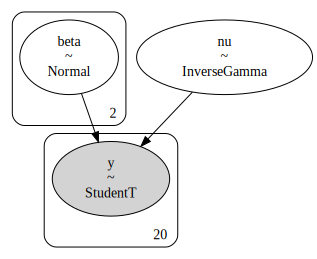

In [12]:
with pm.Model(coords=coords) as mdl_studentt:

    # define weakly informative Normal priors to give Ridge regression
    beta = pm.Normal("beta", mu=0, sigma=10, dims="coefs")

    # define linear model
    y_est = beta[0] + beta[1] * dfhoggs["x"]

    # define prior for StudentT degrees of freedom
    # InverseGamma has nice properties:
    # it's continuous and has support x ∈ (0, inf)
    nu = pm.InverseGamma("nu", alpha=1, beta=1)

    # define Student T likelihood
    pm.StudentT(
        "y", mu=y_est, sigma=dfhoggs["sigma_y"], nu=nu, observed=dfhoggs["y"], dims="datapoint_id"
    )

pm.model_to_graphviz(mdl_studentt)

### 4.2 Fit Model

#### 4.2.1 Sample Posterior

In [13]:
with mdl_studentt:
    trc_studentt = pm.sample(
        tune=5000,
        draws=500,
        chains=4,
        cores=4,
        init="advi+adapt_diag",
        n_init=50000,
        progressbar=True,
        ,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 16700
Interrupted at 16,699 [33%]: Average Loss = 28.092
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, beta]


Sampling 4 chains for 5_000 tune and 500 draw iterations (20_000 + 2_000 draws total) took 8 seconds.


#### 4.2.2 View Diagnostics

NOTE: We will illustrate this StudentT fit and compare to the datapoints in the final comparison plot

Traceplot

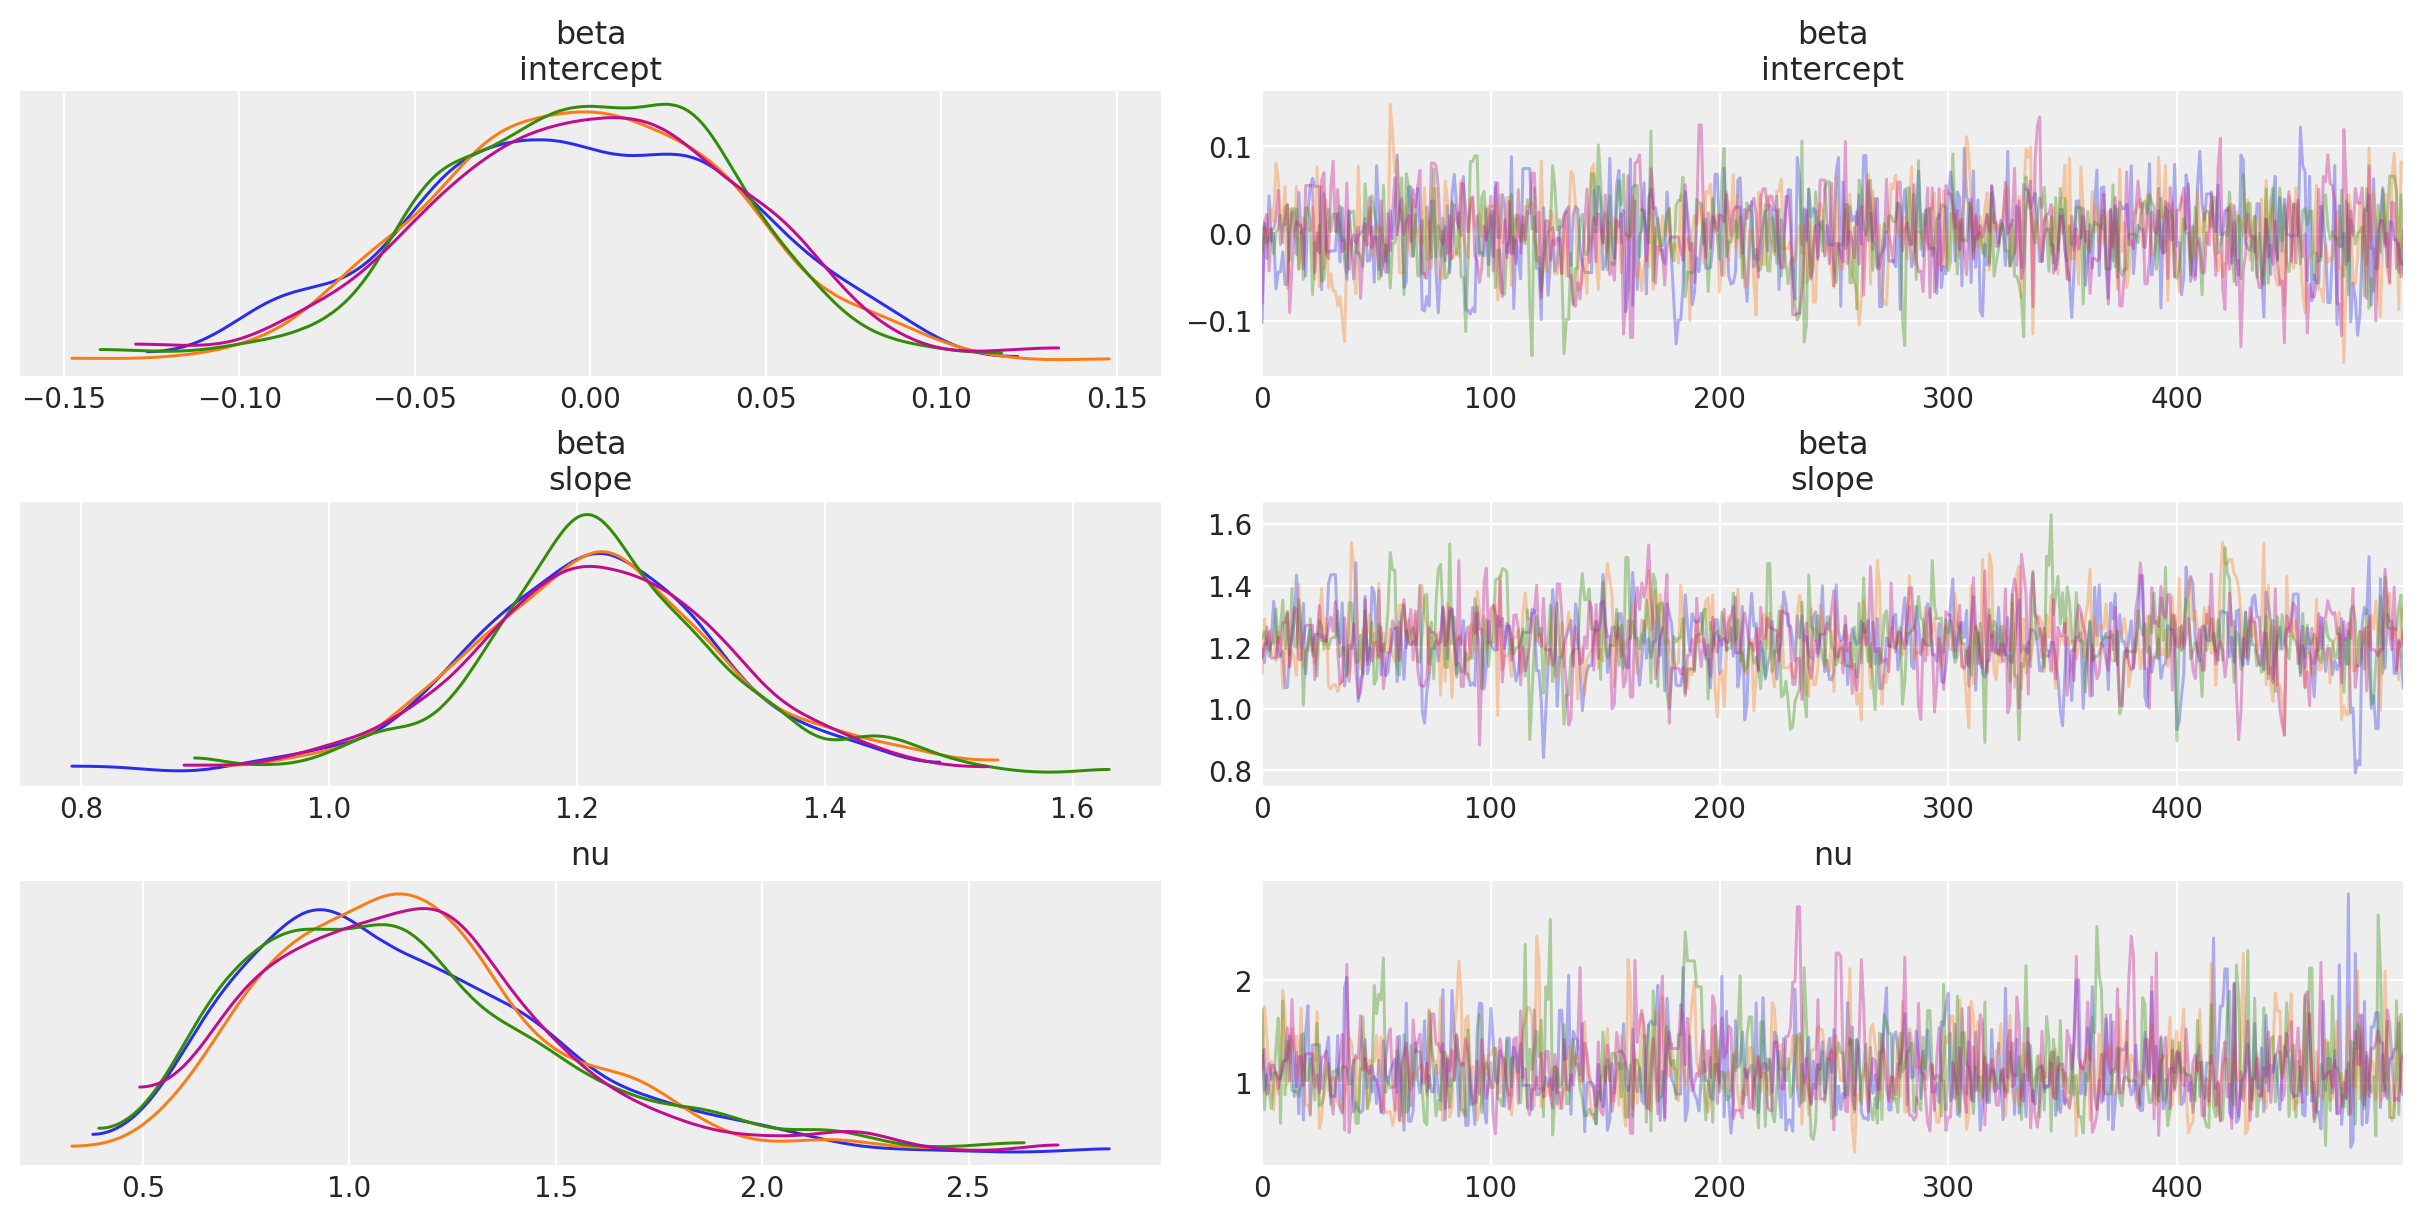

In [14]:
_ = az.plot_trace(trc_studentt, compact=False);

Plot posterior joint distribution

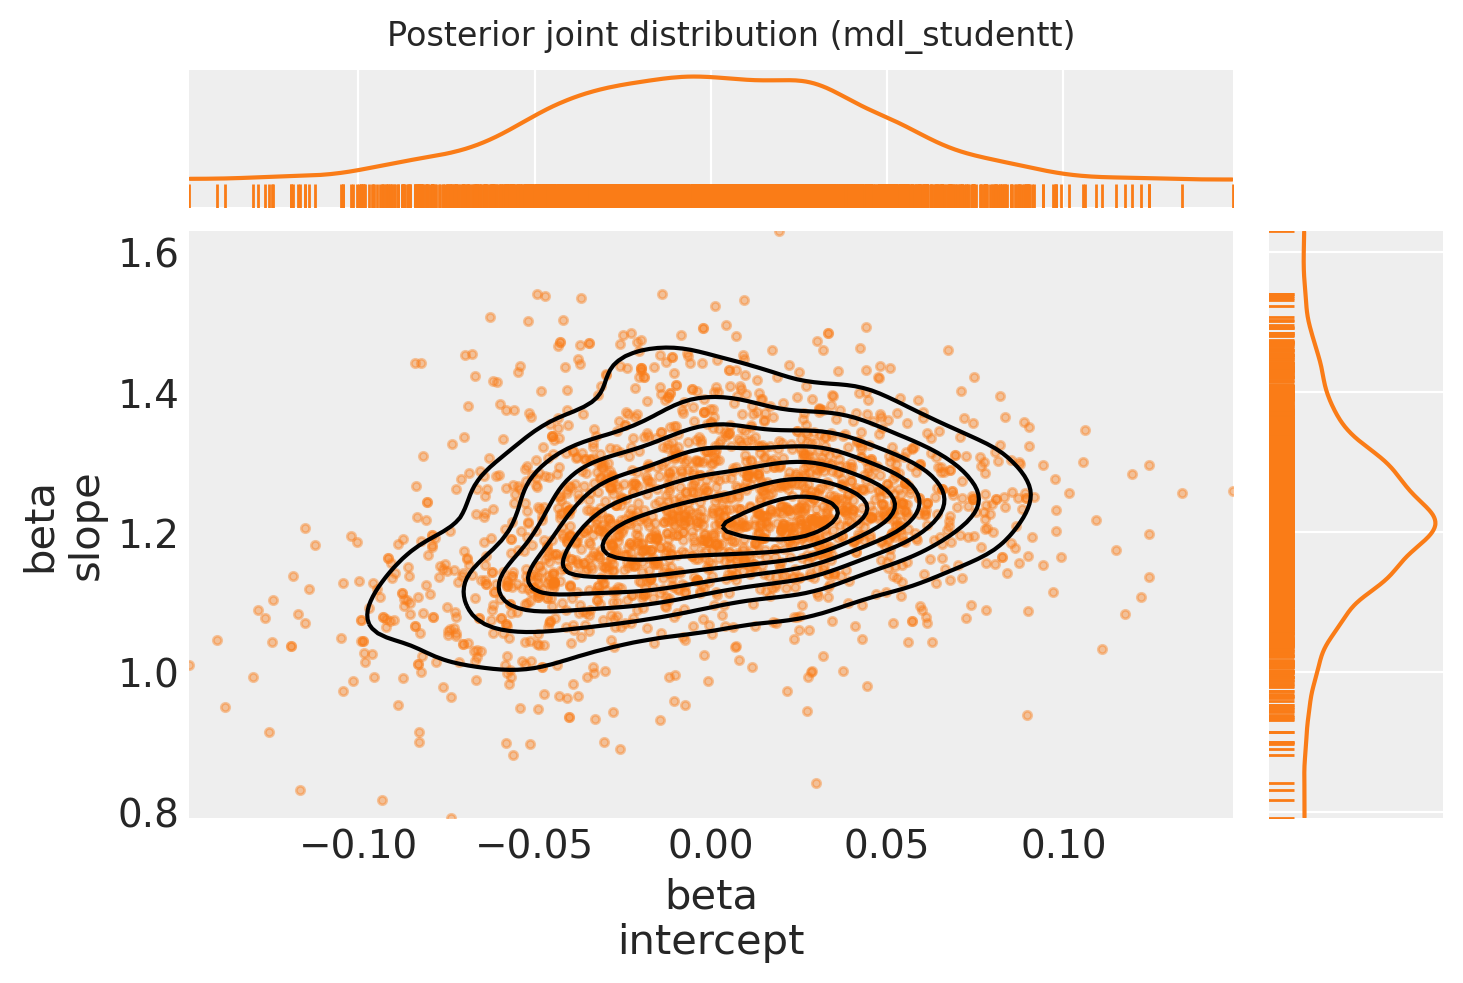

In [15]:
marginal_kwargs["color"] = "C1"
ax = az.plot_pair(
    trc_studentt,
    var_names="beta",
    kind=["scatter", "kde"],
    divergences=True,
    marginals=True,
    marginal_kwargs=marginal_kwargs,
    scatter_kwargs={"color": "C1", "alpha": 0.4},
)
ax[0, 0].get_figure().suptitle("Posterior joint distribution (mdl_studentt)");

#### 4.2.3 View the shift in posterior joint distributions from OLS to StudentT

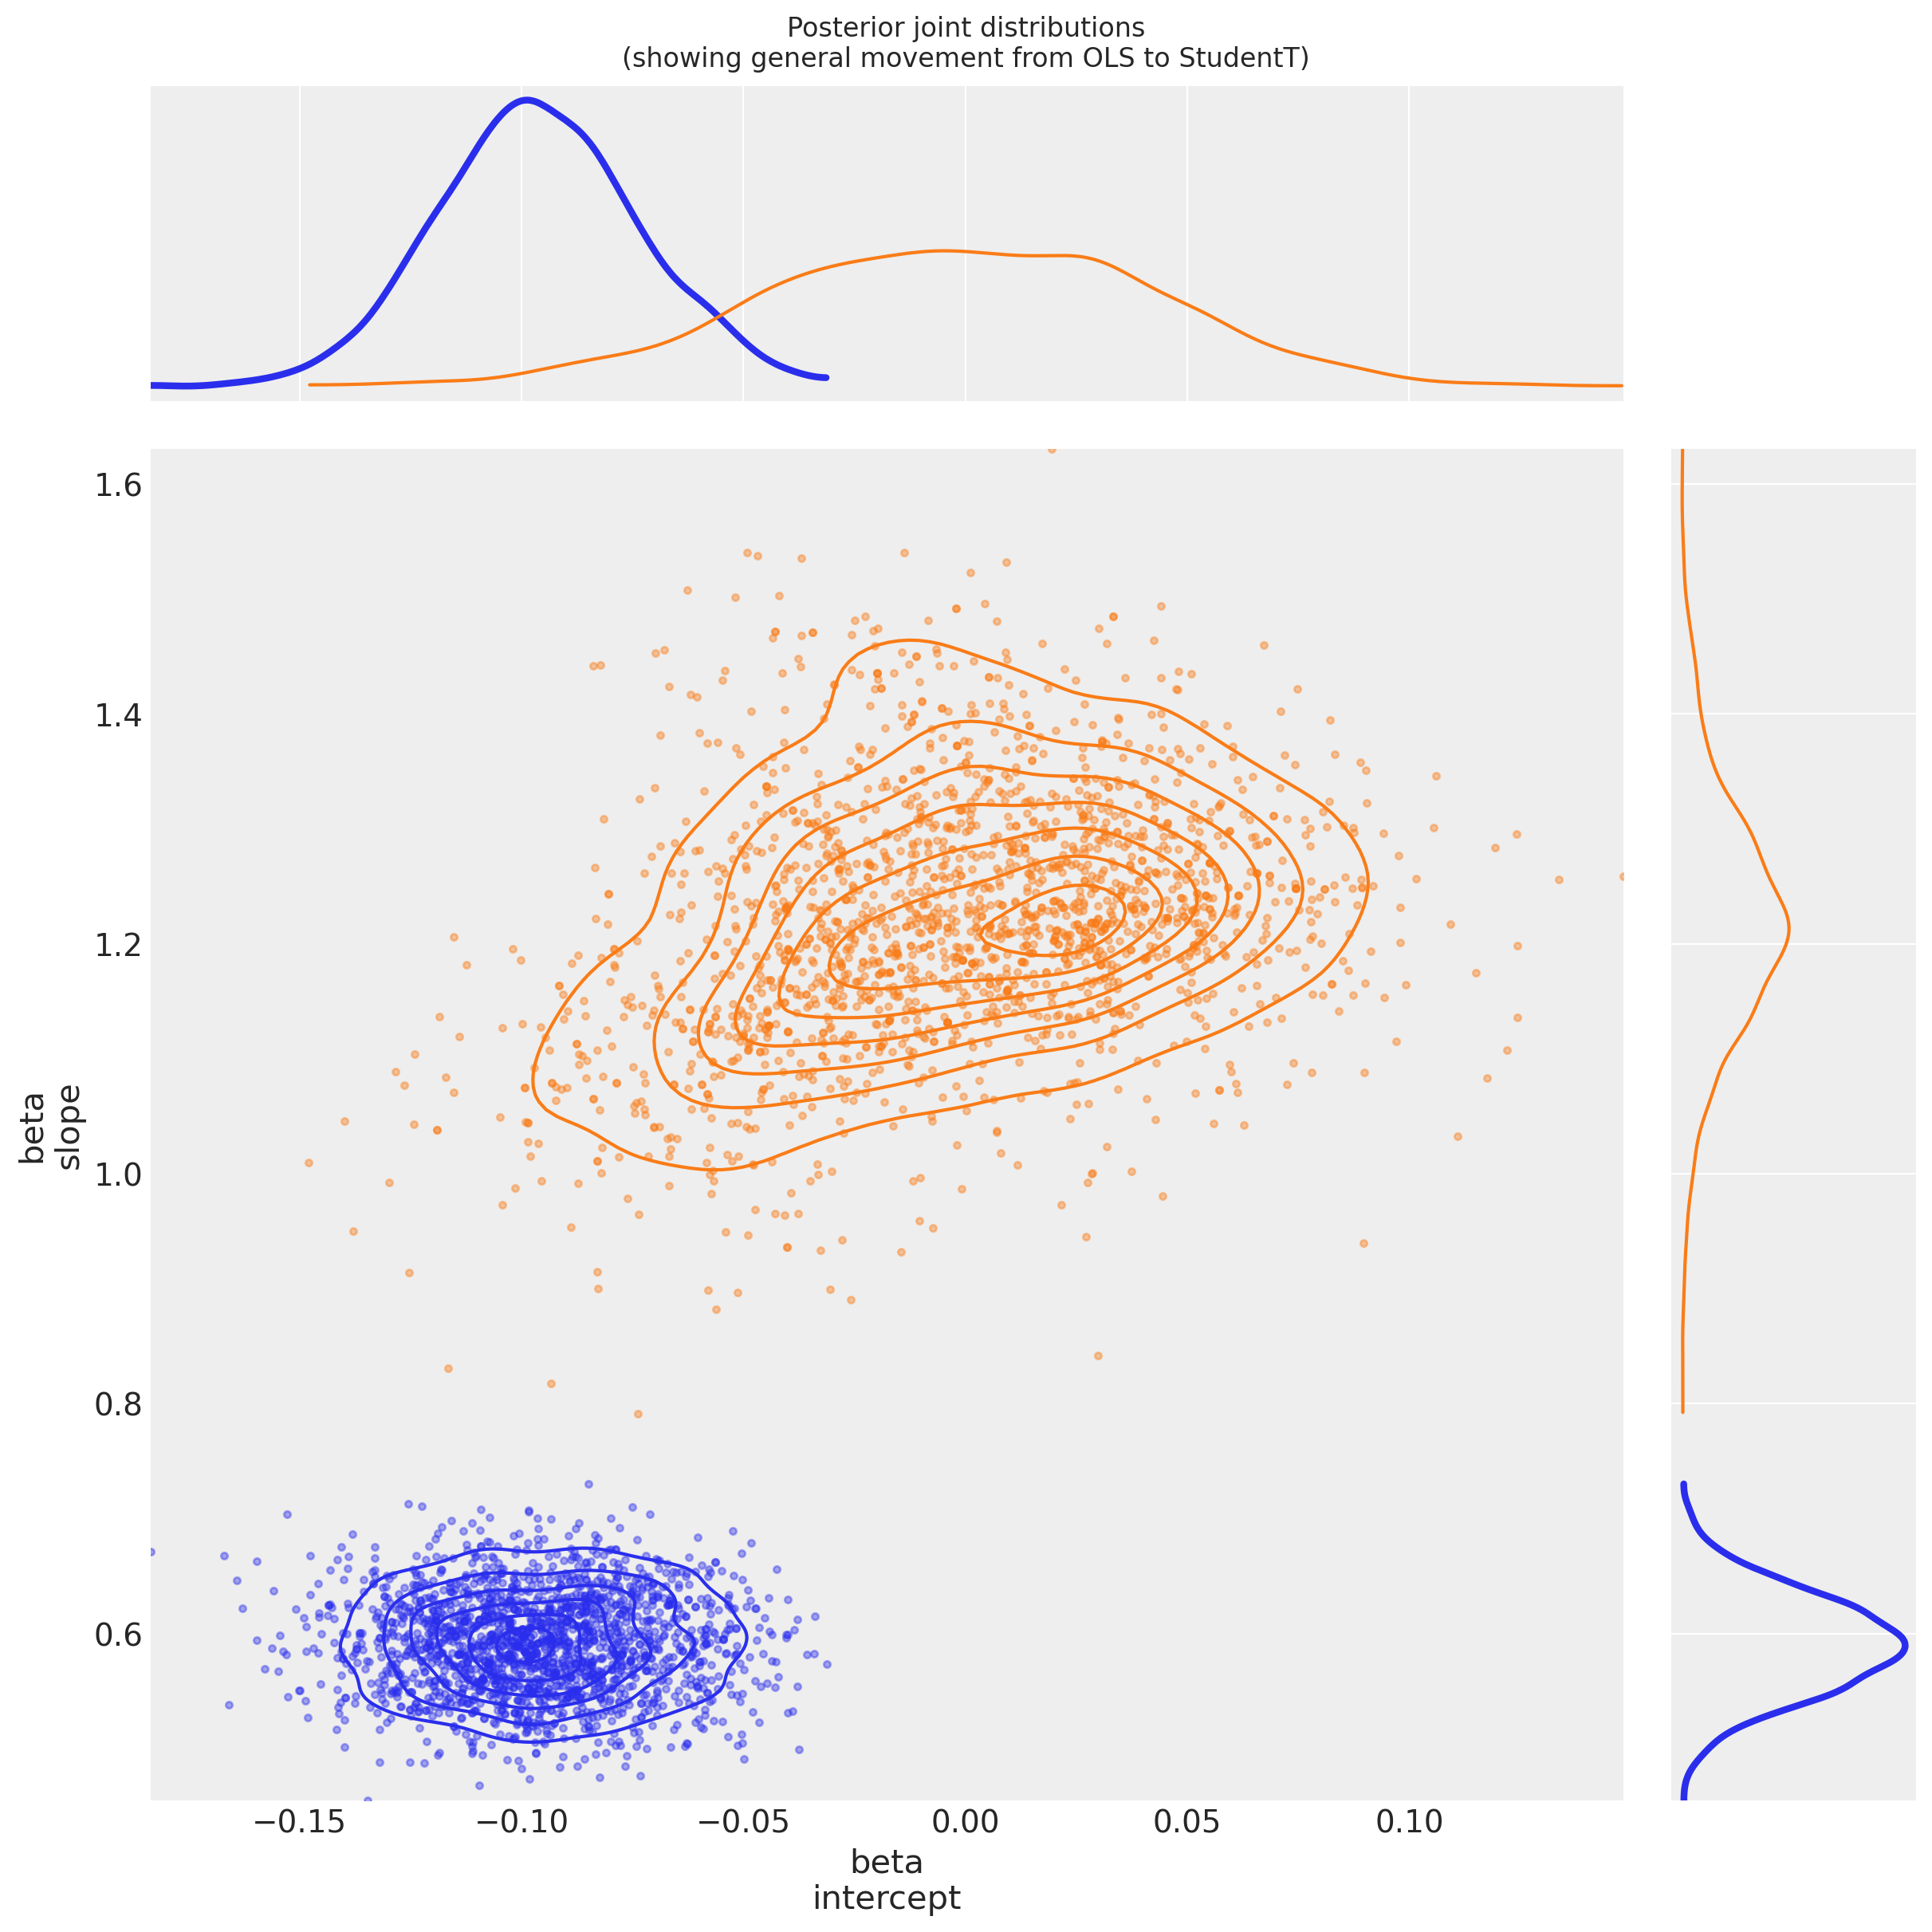

In [16]:
marginal_kwargs["rug"] = False
marginal_kwargs["color"] = "C0"
ax = az.plot_pair(
    trc_ols,
    var_names="beta",
    kind=["scatter", "kde"],
    divergences=True,
    figsize=[12, 12],
    marginals=True,
    marginal_kwargs=marginal_kwargs,
    scatter_kwargs={"color": "C0", "alpha": 0.4},
    kde_kwargs={"contour_kwargs": {"colors": "C0"}},
)

marginal_kwargs["color"] = "C1"
az.plot_pair(
    trc_studentt,
    var_names="beta",
    kind=["scatter", "kde"],
    divergences=True,
    marginals=True,
    marginal_kwargs=marginal_kwargs,
    scatter_kwargs={"color": "C1", "alpha": 0.4},
    kde_kwargs={"contour_kwargs": {"colors": "C1"}},
    ax=ax,
)

ax[0, 0].get_figure().suptitle(
    "Posterior joint distributions\n(showing general movement from OLS to StudentT)"
);

**Observe:**

+ Both `beta` parameters appear to have greater variance than in the OLS regression
+ This is due to $\nu$ appearing to converge to a value `nu ~ 1`, indicating 
  that a fat-tailed likelihood has a better fit than a thin-tailed one
+ The parameter `beta[intercept]` has moved much closer to $0$, which is 
  interesting: if the theoretical relationship `y ~ f(x)` has no offset, 
  then for this mean-centered dataset, the intercept should indeed be $0$: it 
  might easily be getting pushed off-course by outliers in the OLS model.
+ The parameter `beta[slope]` has accordingly become greater: perhaps moving 
  closer to the theoretical function `f(x)`

---

## 5. Linear Model with Custom Likelihood to Distinguish Outliers: Hogg Method

Please read the paper (Hogg 2010) and Jake Vanderplas' code for more complete information about the modelling technique.

The general idea is to create a 'mixture' model whereby datapoints can be described by either:

1. the proposed (linear) model (thus a datapoint is an inlier), or
2. a second model, which for convenience we also propose to be linear, but allow it to have a different mean and variance (thus a datapoint is an outlier)

### 5.1 Specify Model

The likelihood is evaluated over a mixture of two likelihoods, one for 'inliers', one for 'outliers'. A Bernoulli distribution is used to randomly assign datapoints in N to either the inlier or outlier groups, and we sample the model as usual to infer robust model parameters and inlier / outlier flags:

$$
\mathcal{logL} = \sum_{i}^{i=N} log \left[ \frac{(1 - B_{i})}{\sqrt{2 \pi \sigma_{in}^{2}}} exp \left( - \frac{(x_{i} - \mu_{in})^{2}}{2\sigma_{in}^{2}} \right) \right] + \sum_{i}^{i=N} log \left[ \frac{B_{i}}{\sqrt{2 \pi (\sigma_{in}^{2} + \sigma_{out}^{2})}} exp \left( - \frac{(x_{i}- \mu_{out})^{2}}{2(\sigma_{in}^{2} + \sigma_{out}^{2})} \right) \right]
$$

where:  
+ $B_{i}$ is Bernoulli-distibuted $B_{i} \in \{0_{(inlier)},1_{(outlier)}\}$
+ $\mu_{in} = \beta^{T} \vec{x}_{i}$ as before for inliers, where $\beta$ = $\{1, \beta_{j \in X_{j}}\}$  <--- linear coefs in 
$X_{j}$, in this case `1 + x`
+ $\sigma_{in}$ = noise term <--- in this case we set this to an _unpooled_ $\sigma_{i}$: the measured error `sigma_y` for each datapoint
+ $\mu_{out}$ <--- is a random _pooled_ variable for outliers
+ $\sigma_{out}$ = additional noise term <--- is a random _unpooled_ variable for outliers

This notebook uses {func}`~pymc.model.Potential` class combined with `logp` to create a likelihood and build this model where a feature is not observed, here the Bernoulli switching variable.

Usage of `Potential` is not discussed. Other resources are available that are worth referring to for details
on `Potential` usage:

+ [Junpenglao's presentation on likelihoods](https://github.com/junpenglao/All-that-likelihood-with-PyMC) at PyData Berlin July 2018
+ worked examples on [Discourse](https://discourse.pymc.io/t/pm-potential-much-needed-explanation-for-newbie/2341) and [Cross Validated](https://stats.stackexchange.com/a/252607/10625). 
+ and the pymc port of CamDP's Probabilistic Programming and Bayesian Methods for Hackers, Chapter 5 Loss Functions, [Example: Optimizing for the Showcase on The Price is Right](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter5_LossFunctions/Ch5_LossFunctions_PyMC.ipynb)
+ Other examples using it, search for the `pymc.Potential` tag on the left sidebar

In [17]:
with pm.Model(coords=coords) as mdl_hogg:

    # state input data as Aesara shared vars
    tsv_x = pm.Data("tsv_x", dfhoggs["x"], dims="datapoint_id")
    tsv_y = pm.Data("tsv_y", dfhoggs["y"], dims="datapoint_id")
    tsv_sigma_y = pm.Data("tsv_sigma_y", dfhoggs["sigma_y"], dims="datapoint_id")

    # weakly informative Normal priors (L2 ridge reg) for inliers
    beta = pm.Normal("beta", mu=0, sigma=10, dims="coefs")

    # linear model for mean for inliers
    y_est_in = beta[0] + beta[1] * tsv_x  # dims="obs_id"

    # very weakly informative mean for all outliers
    y_est_out = pm.Normal("y_est_out", mu=0, sigma=10, testval=pm.floatX(0.0))

    # very weakly informative prior for additional variance for outliers
    sigma_y_out = pm.HalfNormal("sigma_y_out", sigma=10, testval=pm.floatX(1.0))

    # create in/outlier distributions to get a logp evaluated on the observed y
    # this is not strictly a pymc likelihood, but behaves like one when we
    # evaluate it within a Potential (which is minimised)
    inlier_logp = pm.Normal.dist(mu=y_est_in, sigma=tsv_sigma_y).logp(tsv_y)

    outlier_logp = pm.Normal.dist(mu=y_est_out, sigma=tsv_sigma_y + sigma_y_out).logp(tsv_y)

    # frac_outliers only needs to span [0, .5]
    # testval for is_outlier initialised in order to create class asymmetry
    frac_outliers = pm.Uniform("frac_outliers", lower=0.0, upper=0.5)
    is_outlier = pm.Bernoulli(
        "is_outlier",
        p=frac_outliers,
        testval=(np.random.rand(tsv_x.eval().shape[0]) < 0.4) * 1,
        dims="datapoint_id",
    )

    # non-sampled Potential evaluates the Normal.dist.logp's
    potential = pm.Potential(
        "obs",
        ((1 - is_outlier) * inlier_logp).sum() + (is_outlier * outlier_logp).sum(),
    )

### 5.2 Fit Model

#### 5.2.1 Sample Posterior

Note that `pm.sample` conveniently and automatically creates the compound sampling process to:
1. sample a Bernoulli variable (the class `is_outlier`) using a discrete sampler
2. sample the continuous variables using a continuous sampler

Further note:
+ This also means we can't initialise using ADVI, so will init using `jitter+adapt_diag`
+ In order to pass `kwargs` to a particular stepper, wrap them in a dict addressed to the lowercased [name of the stepper](https://github.com/pymc-devs/pymc/blob/master/pymc/sampling.py) e.g. `nuts={'target_accept': 0.85}`

In [18]:
with mdl_hogg:
    trc_hogg = pm.sample(
        tune=10000,
        draws=500,
        chains=4,
        cores=4,
        init="jitter+adapt_diag",
        nuts={"target_accept": 0.99},
        ,
    )

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [frac_outliers, sigma_y_out, y_est_out, beta]
>BinaryGibbsMetropolis: [is_outlier]


Sampling 4 chains for 10_000 tune and 500 draw iterations (40_000 + 2_000 draws total) took 96 seconds.
/home/oriol/miniconda3/envs/pymc-v3/lib/python3.9/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The number of effective samples is smaller than 25% for some parameters.


#### 5.2.2 View Diagnostics

We will illustrate this model fit and compare to the datapoints in the final comparison plot

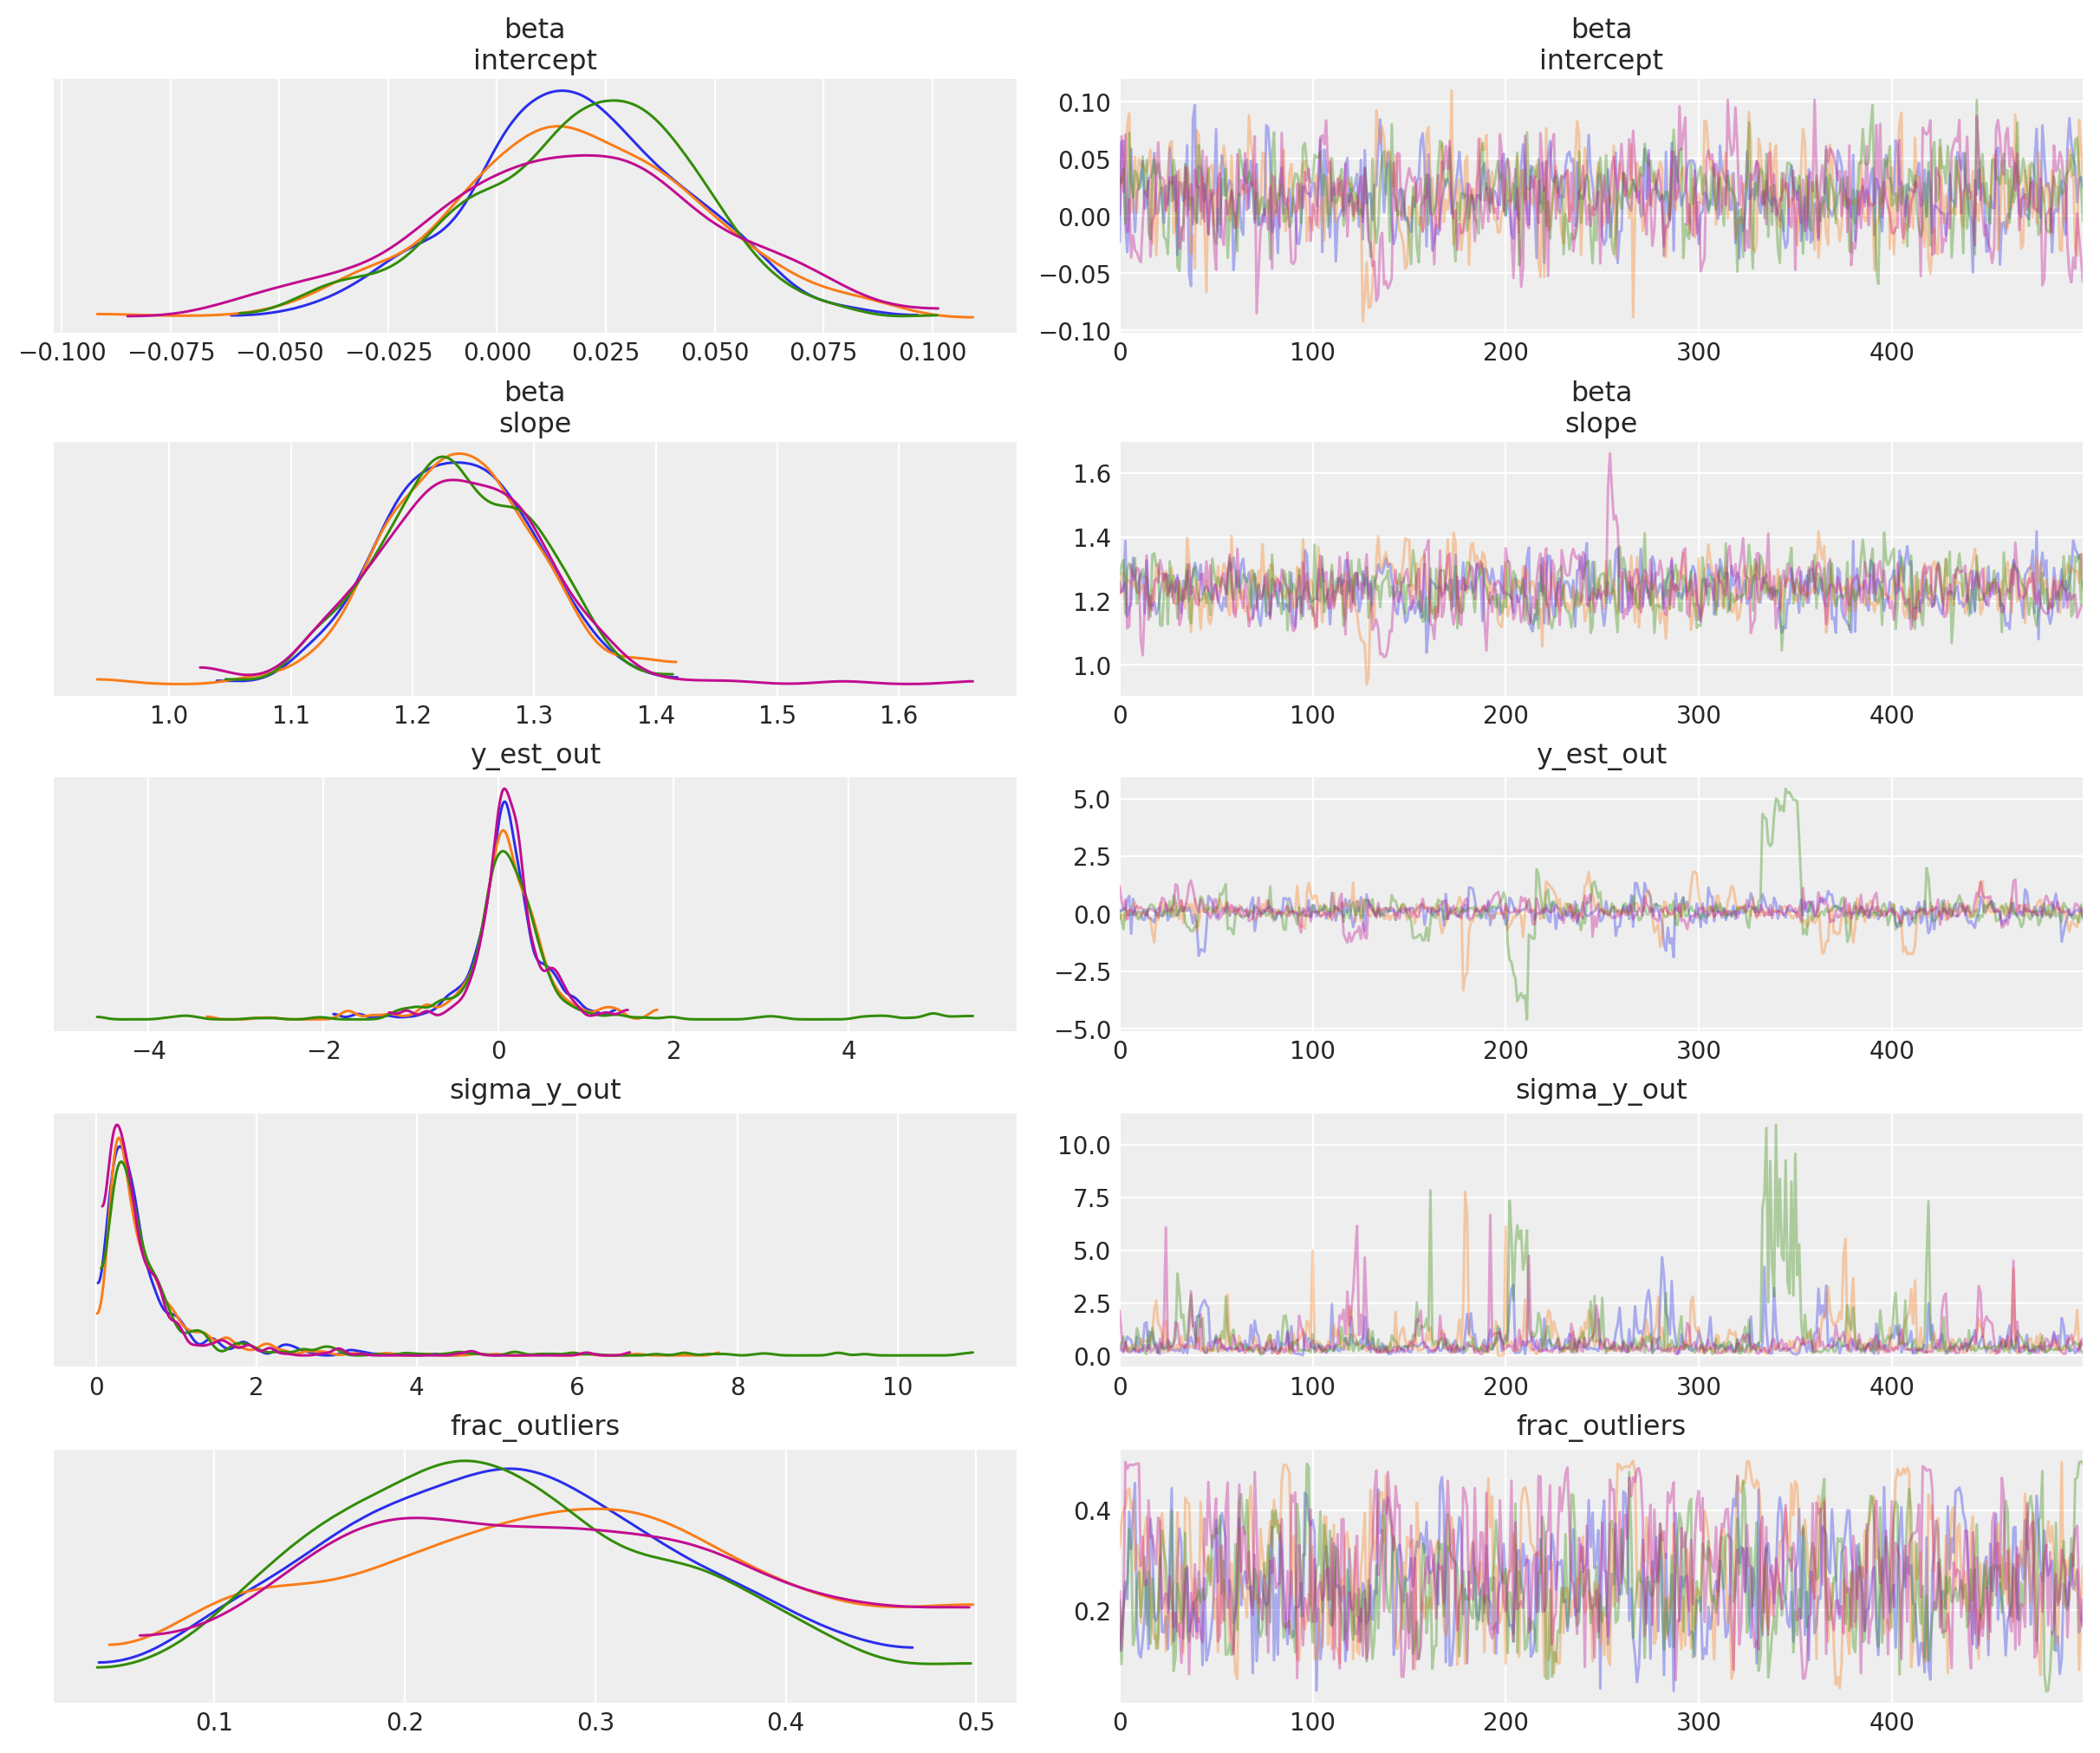

In [19]:
rvs = ["beta", "y_est_out", "sigma_y_out", "frac_outliers"]
_ = az.plot_trace(trc_hogg, var_names=rvs, compact=False);

**Observe:**

+ At the default `target_accept = 0.8` there are lots of divergences, indicating this is not a particularly stable model
+ However, at `target_accept = 0.9` (and increasing `tune` from 5000 to 10000), the traces exhibit fewer divergences and appear slightly better behaved.
+ The traces for the inlier model `beta` parameters, and for outlier model parameter `y_est_out` (the mean) look reasonably converged
+ The traces for outlier model param `y_sigma_out` (the additional pooled variance) occasionally go a bit wild
+ It's interesting that `frac_outliers` is so dispersed: that's quite a flat distribution: suggests that there are a few datapoints where their inlier/outlier status is subjective
+ Indeed as Thomas noted in his v2.0 Notebook, because we're explicitly modeling the latent label (inlier/outlier) as binary choice the sampler could have a problem - rewriting this model into a marginal mixture model would be better.

Simple trace summary inc rhat

In [20]:
az.summary(trc_hogg, var_names=rvs)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[intercept]  0.018  0.030  -0.041    0.072      0.001    0.001     978.0   
beta[slope]      1.238  0.066   1.112    1.349      0.002    0.002     846.0   
y_est_out        0.120  0.669  -1.097    0.929      0.049    0.043     462.0   
sigma_y_out      0.744  1.023   0.009    2.074      0.066    0.047     478.0   
frac_outliers    0.265  0.102   0.090    0.459      0.004    0.003     635.0   

                 ess_tail  r_hat  
beta[intercept]     881.0   1.01  
beta[slope]         882.0   1.00  
y_est_out           324.0   1.01  
sigma_y_out         352.0   1.01  
frac_outliers       442.0   1.01

Plot posterior joint distribution

(This is a particularly useful diagnostic in this case where we see a lot of divergences in the traces: maybe the model specification leads to weird behaviours)

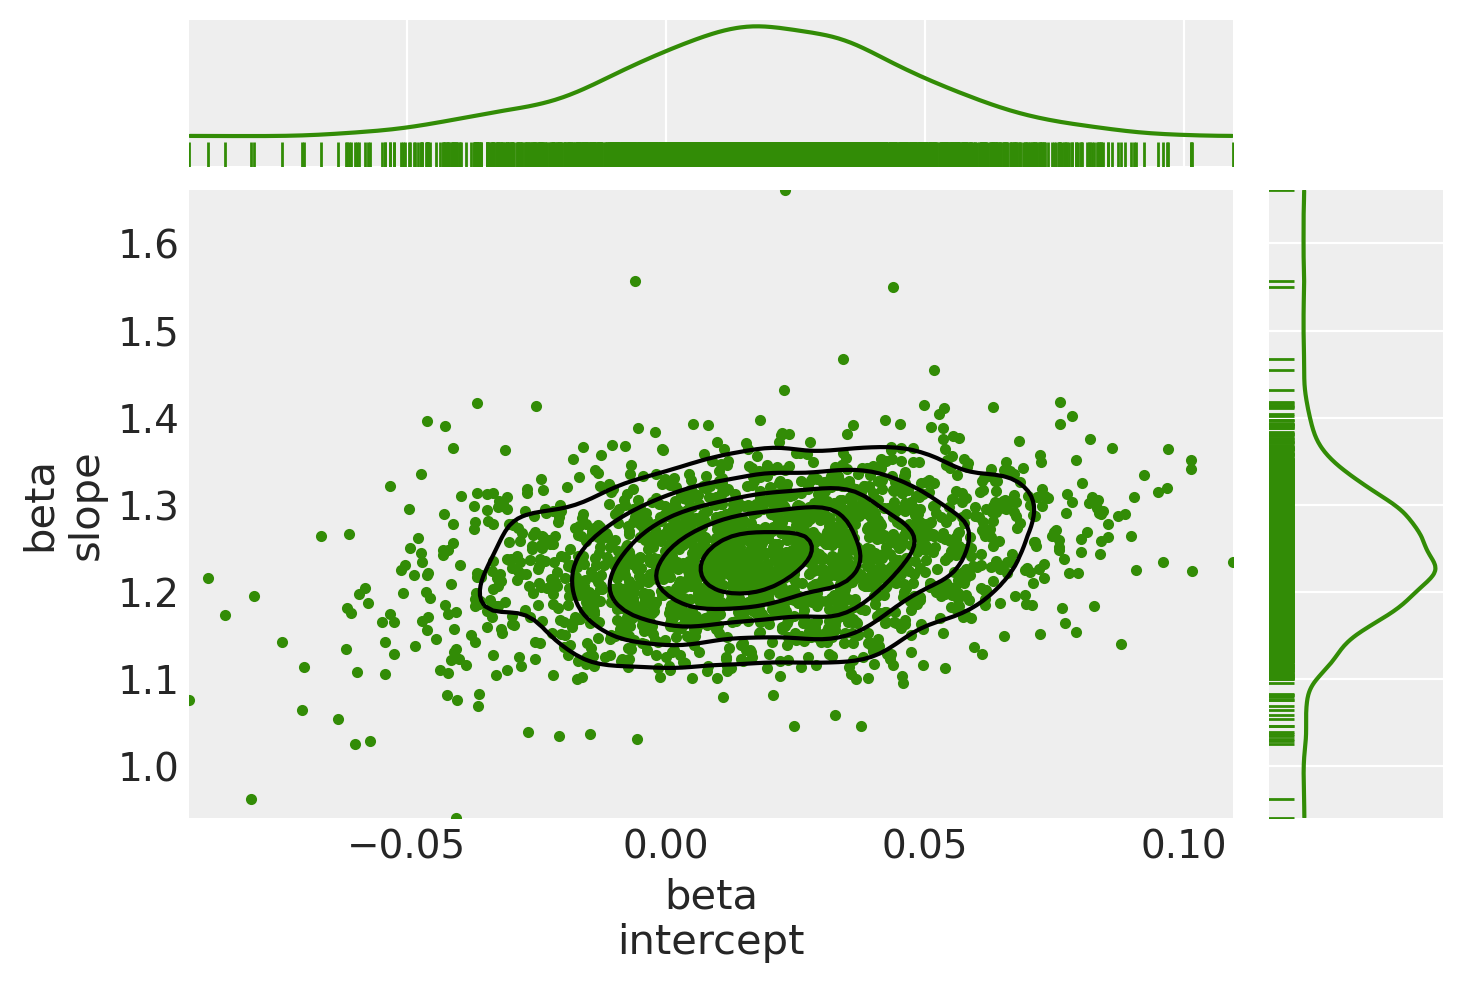

In [21]:
marginal_kwargs["color"] = "C2"
marginal_kwargs["rug"] = True
x = az.plot_pair(
    data=trc_hogg,
    var_names="beta",
    kind=["kde", "scatter"],
    divergences=True,
    marginals=True,
    marginal_kwargs=marginal_kwargs,
    scatter_kwargs={"color": "C2"},
)
ax[0, 0].get_figure().suptitle("Posterior joint distribution (mdl_hogg)");

#### 5.2.3 View the shift in posterior joint distributions from OLS to StudentT to Hogg

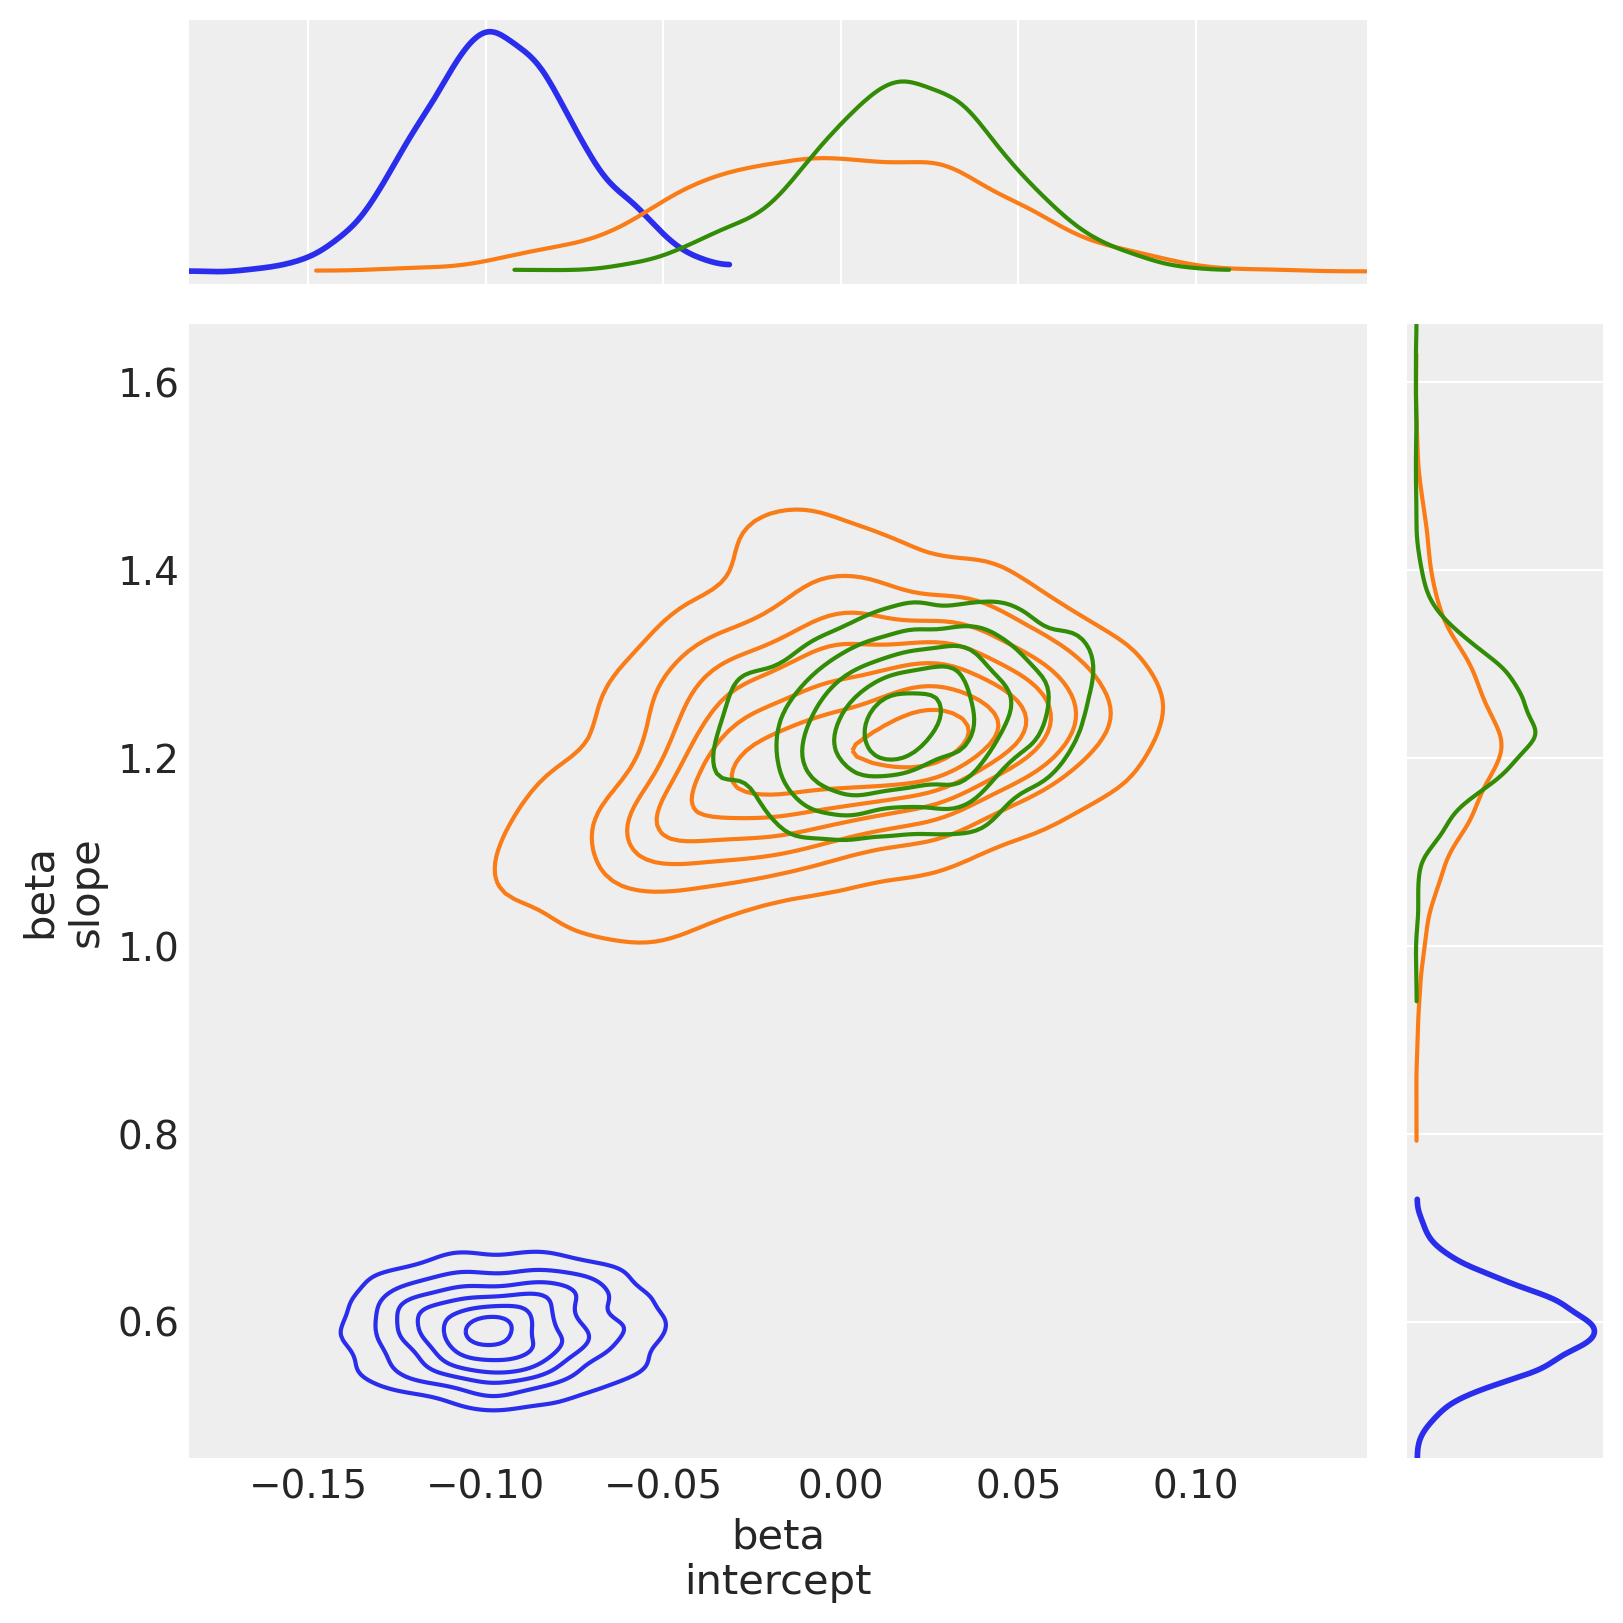

In [22]:
kde_kwargs = {"contour_kwargs": {"colors": "C0", "zorder": 4}, "contourf_kwargs": {"alpha": 0}}
marginal_kwargs["rug"] = False
marginal_kwargs["color"] = "C0"
ax = az.plot_pair(
    trc_ols,
    var_names="beta",
    kind="kde",
    divergences=True,
    marginals=True,
    marginal_kwargs={"color": "C0"},
    kde_kwargs=kde_kwargs,
    figsize=(8, 8),
)

marginal_kwargs["color"] = "C1"
kde_kwargs["contour_kwargs"]["colors"] = "C1"
az.plot_pair(
    trc_studentt,
    var_names="beta",
    kind="kde",
    divergences=True,
    marginals=True,
    marginal_kwargs=marginal_kwargs,
    kde_kwargs=kde_kwargs,
    ax=ax,
)

marginal_kwargs["color"] = "C2"
kde_kwargs["contour_kwargs"]["colors"] = "C2"
az.plot_pair(
    data=trc_hogg,
    var_names="beta",
    kind="kde",
    divergences=True,
    marginals=True,
    marginal_kwargs=marginal_kwargs,
    kde_kwargs=kde_kwargs,
    ax=ax,
    show=True,
)
ax[0, 0].get_figure().suptitle(
    "Posterior joint distributions" + "\nOLS, StudentT, and Hogg (inliers)"
);

**Observe:**

+ The `hogg_inlier` and `studentt` models converge to similar ranges for 
`b0_intercept` and `b1_slope`, indicating that the (unshown) `hogg_outlier` 
model might perform a similar job to the fat tails of the `studentt` model: 
allowing greater log probability away from the main linear distribution in the datapoints
+ As expected, (since it's a Normal) the `hogg_inlier` posterior has thinner 
 tails and more probability mass concentrated about the central values
+ The `hogg_inlier` model also appears to have moved farther away from both the 
`ols` and `studentt` models on the `b0_intercept`, suggesting that the outliers 
really distort that particular dimension

### 5.3 Declare Outliers

#### 5.3.1 View ranges for inliers / outlier predictions

At each step of the traces, each datapoint may be either an inlier or outlier. We hope that the datapoints spend an unequal time being one state or the other, so let's take a look at the simple count of states for each of the 20 datapoints.

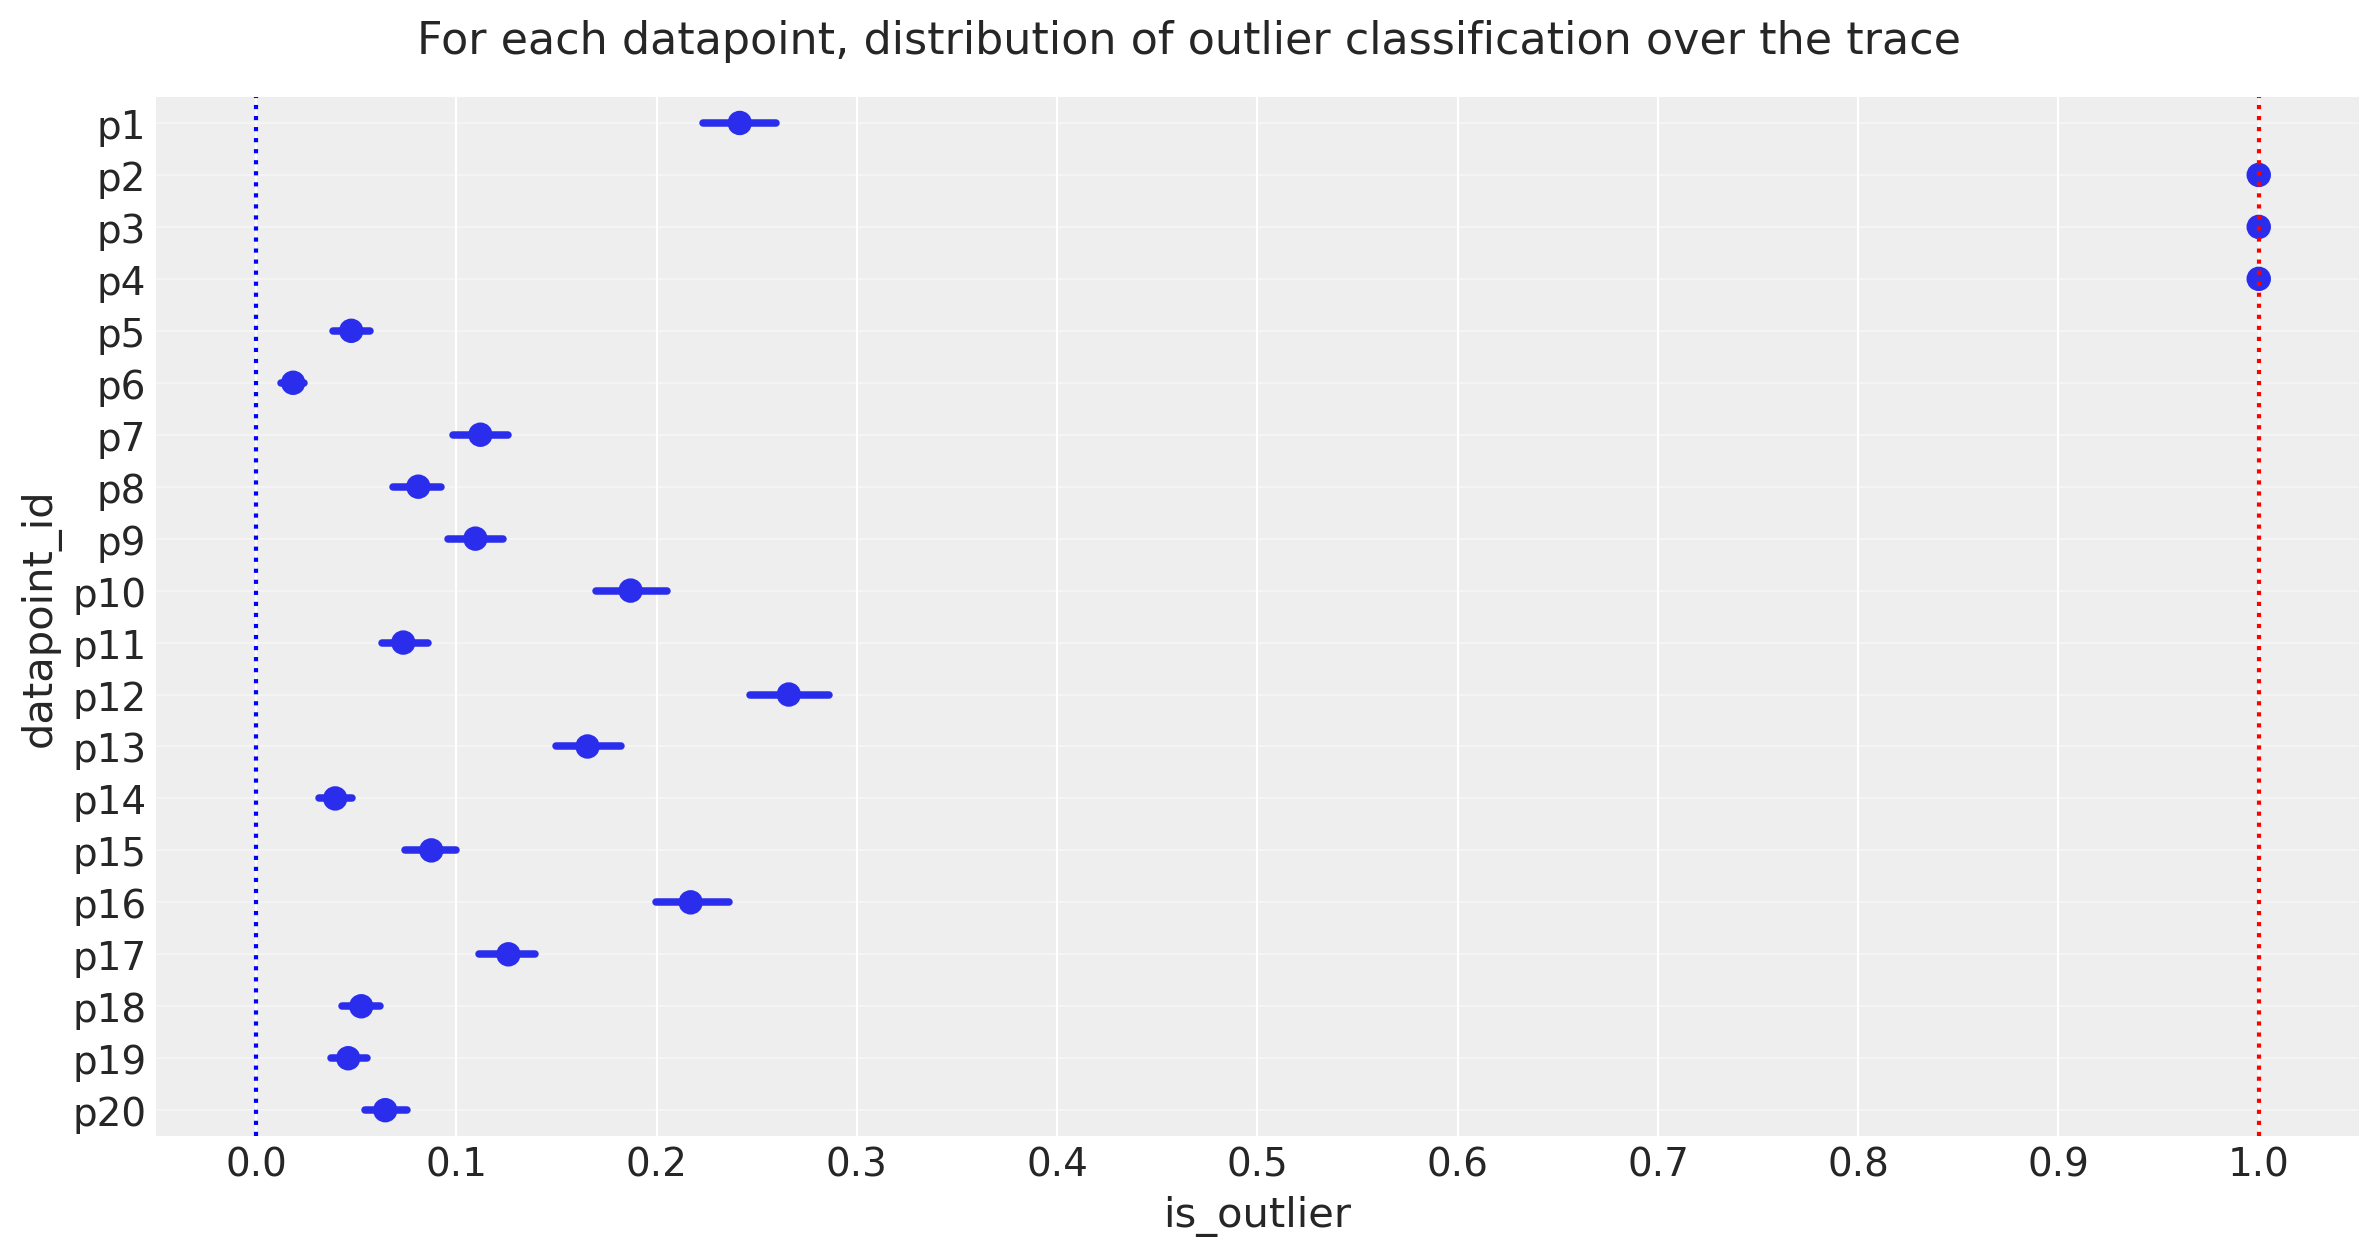

In [23]:
dfm_outlier_results = trc_hogg.posterior.is_outlier.to_dataframe().reset_index()

with plt.rc_context({"figure.constrained_layout.use": False}):
    gd = sns.catplot(
        y="datapoint_id",
        x="is_outlier",
        data=dfm_outlier_results,
        kind="point",
        join=False,
        height=6,
        aspect=2,
    )
_ = gd.fig.axes[0].set(xlim=(-0.05, 1.05), xticks=np.arange(0, 1.1, 0.1))
_ = gd.fig.axes[0].axvline(x=0, color="b", linestyle=":")
_ = gd.fig.axes[0].axvline(x=1, color="r", linestyle=":")
_ = gd.fig.axes[0].yaxis.grid(True, linestyle="-", which="major", color="w", alpha=0.4)
_ = gd.fig.suptitle(
    ("For each datapoint, distribution of outlier classification " + "over the trace"),
    y=1.04,
    fontsize=16,
)

**Observe**:

+ The plot above shows the proportion of samples in the traces in which each datapoint is marked as an outlier, expressed as a percentage.
+ 3 points [p2, p3, p4] spend >=95% of their time as outliers
+ Note the mean posterior value of `frac_outliers ~ 0.27`, corresponding to approx 5 or 6 of the 20 datapoints: we might investigate datapoints `[p1, p12, p16]` to see if they lean towards being outliers

The 95% cutoff we choose is subjective and arbitrary, but I prefer it for now, so let's declare these 3 to be outliers and see how it looks compared to Jake Vanderplas' outliers, which were declared in a slightly different way as points with means above 0.68.

#### 5.3.2 Declare outliers

**Note:**
+ I will declare outliers to be datapoints that have value == 1 at the 5-percentile cutoff, i.e. in the percentiles from 5 up to 100, their values are 1. 
+ Try for yourself altering cutoff to larger values, which leads to an objective ranking of outlier-hood.

In [24]:
cutoff = 0.05
dfhoggs["classed_as_outlier"] = (
    trc_hogg.posterior["is_outlier"].quantile(cutoff, dim=("chain", "draw")) == 1
)
dfhoggs["classed_as_outlier"].value_counts()

False    17
True      3
Name: classed_as_outlier, dtype: int64

Also add flag for points to be investigated. Will use this to annotate final plot

In [25]:
dfhoggs["annotate_for_investigation"] = (
    trc_hogg.posterior["is_outlier"].quantile(0.75, dim=("chain", "draw")) == 1
)
dfhoggs["annotate_for_investigation"].value_counts()

False    16
True      4
Name: annotate_for_investigation, dtype: int64

### 5.4 Posterior Prediction Plots for OLS vs StudentT vs Hogg "Signal vs Noise"

In [26]:
import xarray as xr

x = xr.DataArray(np.linspace(-3, 3, 10), dims="plot_dim")

# evaluate outlier posterior distribution for plotting
trc_hogg.posterior["outlier_mean"] = trc_hogg.posterior["y_est_out"].broadcast_like(x)

# evaluate model (inlier) posterior distributions for all 3 models
lm = lambda beta, x: beta.sel(coefs="intercept") + beta.sel(coefs="slope") * x

trc_ols.posterior["y_mean"] = lm(trc_ols.posterior["beta"], x)
trc_studentt.posterior["y_mean"] = lm(trc_studentt.posterior["beta"], x)
trc_hogg.posterior["y_mean"] = lm(trc_hogg.posterior["beta"], x)

In [27]:
def subsample_helper(da, samples=100, seed=None):
    da = da.stack(sample=("chain", "draw"))
    rng = np.random.default_rng(seed)
    n = len(da.sample)
    return da.isel(sample=rng.choice(n, samples, replace=False))

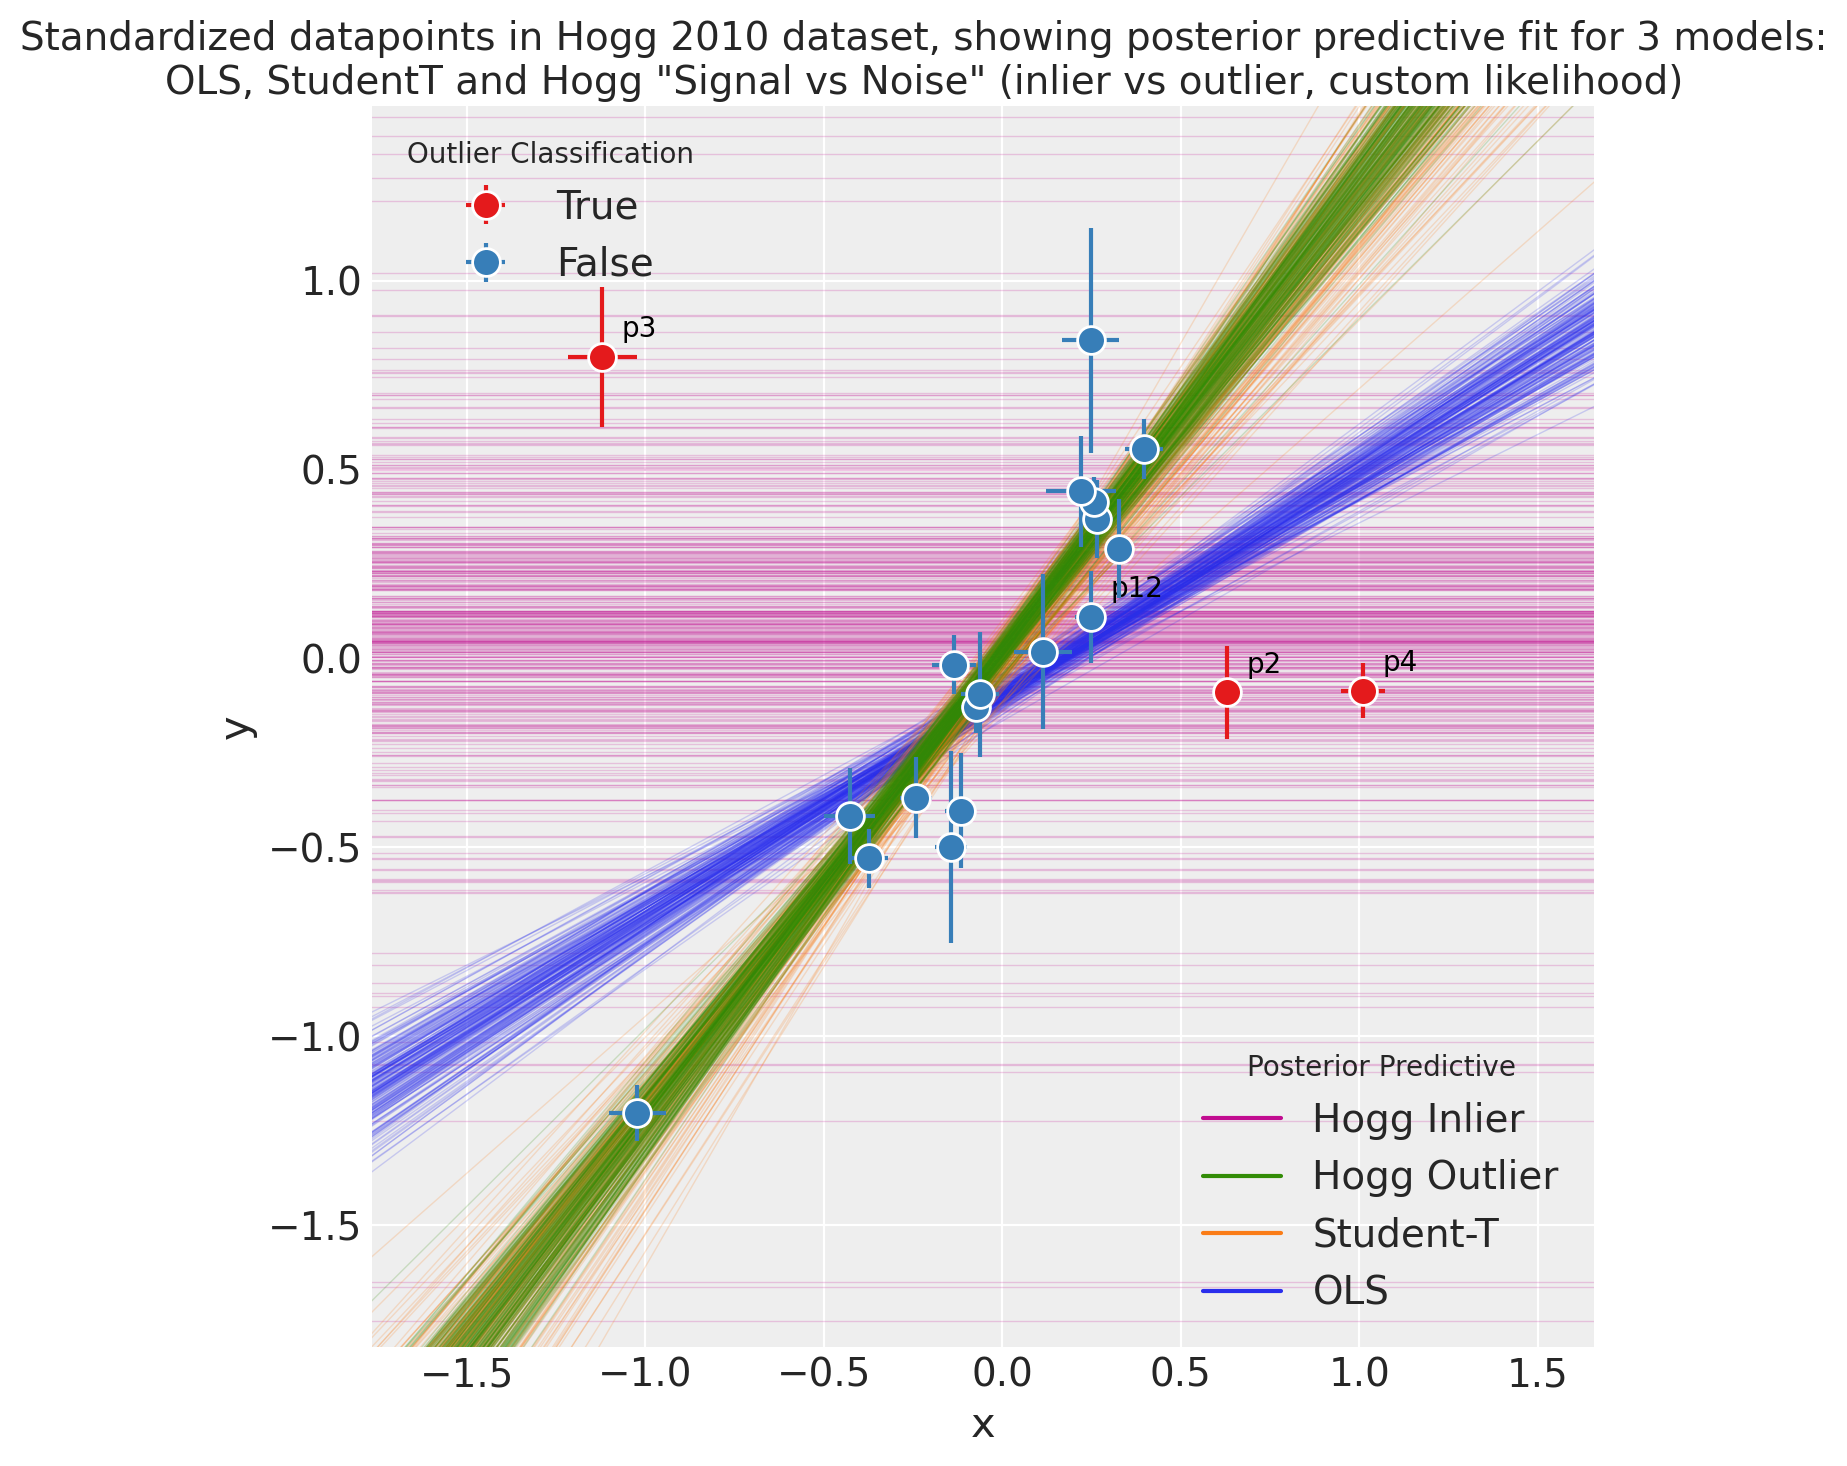

In [28]:
with plt.rc_context({"figure.constrained_layout.use": False}):
    gd = sns.FacetGrid(
        dfhoggs,
        height=7,
        hue="classed_as_outlier",
        hue_order=[True, False],
        palette="Set1",
        legend_out=False,
    )

# plot hogg outlier posterior distribution
outlier_mean = subsample_helper(trc_hogg.posterior["outlier_mean"], 400)
gd.ax.plot(x, outlier_mean, color="C3", linewidth=0.5, alpha=0.2, zorder=1)

# plot the 3 model (inlier) posterior distributions
y_mean = subsample_helper(trc_ols.posterior["y_mean"], 200)
gd.ax.plot(x, y_mean, color="C0", linewidth=0.5, alpha=0.2, zorder=2)

y_mean = subsample_helper(trc_studentt.posterior["y_mean"], 200)
gd.ax.plot(x, y_mean, color="C1", linewidth=0.5, alpha=0.2, zorder=3)

y_mean = subsample_helper(trc_hogg.posterior["y_mean"], 200)
gd.ax.plot(x, y_mean, color="C2", linewidth=0.5, alpha=0.2, zorder=4)

# add legend for regression lines plotted above
line_legend = plt.legend(
    [
        Line2D([0], [0], color="C3"),
        Line2D([0], [0], color="C2"),
        Line2D([0], [0], color="C1"),
        Line2D([0], [0], color="C0"),
    ],
    ["Hogg Inlier", "Hogg Outlier", "Student-T", "OLS"],
    loc="lower right",
    title="Posterior Predictive",
)
gd.ax.add_artist(line_legend)

# plot points
_ = gd.map(
    plt.errorbar,
    "x",
    "y",
    "sigma_y",
    "sigma_x",
    marker="o",
    ls="",
    markeredgecolor="w",
    markersize=10,
    zorder=5,
).add_legend()
gd.ax.legend(loc="upper left", title="Outlier Classification")

# annotate the potential outliers
for idx, r in dfhoggs.loc[dfhoggs["annotate_for_investigation"]].iterrows():
    _ = gd.ax.annotate(
        text=idx,
        xy=(r["x"], r["y"]),
        xycoords="data",
        xytext=(7, 7),
        textcoords="offset points",
        color="k",
        zorder=4,
    )

## create xlims ylims for plotting
x_ptp = np.ptp(dfhoggs["x"].values) / 3.3
y_ptp = np.ptp(dfhoggs["y"].values) / 3.3
xlims = (dfhoggs["x"].min() - x_ptp, dfhoggs["x"].max() + x_ptp)
ylims = (dfhoggs["y"].min() - y_ptp, dfhoggs["y"].max() + y_ptp)
gd.ax.set(ylim=ylims, xlim=xlims)
gd.fig.suptitle(
    (
        "Standardized datapoints in Hogg 2010 dataset, showing "
        "posterior predictive fit for 3 models:\nOLS, StudentT and Hogg "
        '"Signal vs Noise" (inlier vs outlier, custom likelihood)'
    ),
    y=1.04,
    fontsize=14,
);

**Observe**:

The posterior preditive fit for:
+ the **OLS model** is shown in **Green** and as expected, it doesn't appear to fit the majority of our datapoints very well, skewed by outliers
+ the **Student-T model** is shown in **Orange** and does appear to fit the 'main axis' of datapoints quite well, ignoring outliers
+ the **Hogg Signal vs Noise model** is shown in two parts:
    + **Blue** for inliers fits the 'main axis' of datapoints well, ignoring outliers
    + **Red** for outliers has a very large variance and has assigned 'outlier' points with more log likelihood than the Blue inlier model 
    
    
We see that the **Hogg Signal vs Noise model** also yields specific estimates of _which_ datapoints are outliers:
+ 17 'inlier' datapoints, in **Blue** and
+ 3 'outlier' datapoints shown in **Red**.
+ From a simple visual inspection, the classification seems fair, and agrees with Jake Vanderplas' findings.
+ I've annotated these Red and the most outlying inliers to aid visual investigation
    
    
Overall:
+ the **Hogg Signal vs Noise model** behaves as promised, yielding a robust regression estimate and explicit labelling of inliers / outliers, but
+ the **Hogg Signal vs Noise model** is quite complex, and whilst the regression seems robust, the traceplot shoes many divergences, and the model is potentially unstable
+ if you simply want a robust regression without inlier / outlier labelling, the **Student-T model** may be a good compromise, offering a simple model, quick sampling, and a very similar estimate.

## References

:::{bibliography}
:filter: docname in docnames
:::

## Authors

* Authored and adapted for this collection by Jon Sedar ([jonsedar](https://github.com/jonsedar)) on December, 2015. It was originally posted in [jonsedar/pymc_examples](https://github.com/jonsedar/pymc_examples)
* Updated by Thomas Wiecki ([twiecki](https://github.com/twiecki)) on July, 2018
  * Restate outlier model using `pm.Normal.dist().logp()` and `pm.Potential()`
* Updated by Jon Sedar on November, 2019
  * Restate `nu` in StudentT model to be more efficient, drop explicit use of aesara shared vars, generally improve plotting / explanations / layout
* Updated by Jon Sedar on May, 2020
  * Tidyup language, formatting, plots and warnings and rerun with pymc=3.8, arviz=0.7
* Updated by Raul Maldonado ([CloudChaoszero](https://github.com/CloudChaoszero)) on April, 2021
  * Tidyup language, formatting, set MultiTrace objects to `arviz.InferenceData` objects, running on pymc=3.11, arviz=0.11.0
* Updated by Raul Maldonado on May, 2021
  * Update Visualizations from Matplotlib explicit calls to Arviz visualizations. objects, running on pymc=3.11, arviz=0.11.0
* Updated by Oriol Abril on November, 2021

## Watermark

In [29]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,xarray

Last updated: Wed Nov 17 2021

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

aesara: 1.1.2
xarray: 0.20.1

numpy     : 1.21.4
matplotlib: 3.4.3
xarray    : 0.20.1
seaborn   : 0.11.2
pandas    : 1.3.4
scipy     : 1.7.2
pymc     : 3.11.4
arviz     : 0.11.4

Watermark: 2.2.0



:::{include} ../page_footer.md
:::